The task:  
Paraphrase of the emails: We’ve collected five years’ worth of data. One of the major financial risks we've identified is when companies we invest in go bankrupt, which negatively impacts our investment strategies. We'd like to analyze our historical data to see if we can predict whether a company is likely to go bankrupt at some point — not the exact year, just whether it will happen or not. If we can identify such companies in advance, we can divest early to reduce losses.

- The dataset spans five years.
- The prediction target is binary: bankrupt or not, regardless of when.
- The focus remains on proactive investment decisions.

## Data Dictionary

Variables: 

- X1: Net profit / total assets  
- X2: Total liabilities / total assets  
- X3: Working capital / total assets  
- X4: Current assets / short-term liabilities  
- X5: [(Cash + short-term securities + receivables - short-term liabilities) / (Operating expenses - depreciation)] × 365  
- X6: Retained earnings / total assets  
- X7: EBIT / total assets  
- X8: Book value of equity / total liabilities  
- X9: Sales / total assets  
- X10: Equity / total assets  
- X11: (Gross profit + extraordinary items + financial expenses) / total assets  
- X12: Gross profit / short-term liabilities  
- X13: (Gross profit + depreciation) / sales  
- X14: (Gross profit + interest) / total assets  
- X15: (Total liabilities × 365) / (Gross profit + depreciation)  
- X16: (Gross profit + depreciation) / total liabilities  
- X17: Total assets / total liabilities  
- X18: Gross profit / total assets  
- X19: Gross profit / sales  
- X20: (Inventory × 365) / sales  
- X21: Sales (n) / sales (n–1)  
- X22: Profit on operating activities / total assets  
- X23: Net profit / sales  
- X24: Gross profit (in 3 years) / total assets  
- X25: (Equity – share capital) / total assets  
- X26: (Net profit + depreciation) / total liabilities  
- X27: Profit on operating activities / financial expenses  
- X28: Working capital / fixed assets  
- X29: Logarithm of total assets  
- X30: (Total liabilities – cash) / sales  
- X31: (Gross profit + interest) / sales  
- X32: (Current liabilities × 365) / cost of products sold  
- X33: Operating expenses / short-term liabilities  
- X34: Operating expenses / total liabilities  
- X35: Profit on sales / total assets  
- X36: Total sales / total assets  
- X37: (Current assets – inventories) / long-term liabilities  
- X38: Constant capital / total assets  
- X39: Profit on sales / sales  
- X40: (Current assets – inventory – receivables) / short-term liabilities  
- X41: Total liabilities / ((Profit on operating activities + depreciation) × (12/365))  
- X42: Profit on operating activities / sales  
- X43: Rotation receivables + inventory turnover in days  
- X44: (Receivables × 365) / sales  
- X45: Net profit / inventory  
- X46: (Current assets – inventory) / short-term liabilities  
- X47: (Inventory × 365) / cost of products sold  
- X48: EBITDA (Profit on operating activities – depreciation) / total assets  
- X49: EBITDA (Profit on operating activities – depreciation) / sales  
- X50: Current assets / total liabilities  
- X51: Short-term liabilities / total assets  
- X52: (Short-term liabilities × 365) / cost of products sold  
- X53: Equity / fixed assets  
- X54: Constant capital / fixed assets  
- X55: Working capital  
- X56: (Sales – cost of products sold) / sales  
- X57: (Current assets – inventory – short-term liabilities) / (Sales – gross profit – depreciation)  
- X58: Total costs / total sales  
- X59: Long-term liabilities / equity  
- X60: Sales / inventory  
- X61: Sales / receivables  
- X62: (Short-term liabilities × 365) / sales  
- X63: Sales / short-term liabilities  
- X64: Sales / fixed assets  


## Import Libraries And Set Seed

In [51]:
import os
import arff
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, auc, roc_auc_score, roc_curve, RocCurveDisplay
import xgboost as xgb

%matplotlib inline

SEED = 13

## Import and View Data

In [52]:
# # Useful for checking current directory and seeing what files are in a directory
# print(os.getcwd())
# print("Files found:", os.listdir(directory))

In [53]:
# Set eval to True to run this cell
eval = False

# I was going to originally import as with read_csv skipping the header
# The datatypes were sometimes importing as objects, sometimes ints and sometimes floats
# Looping throught the folders was causing mixed datatypes in some columns

# Make evaluation conditional:
if eval:
    # Set the directory containing your CSV files
    directory = '/Users/kdhenderson/Desktop/currentDesktop/SMU/ds7333_QTW/caseStudy04/data'
    
    # Create an empty DataFrame to store combined results
    combined_df = pd.DataFrame()
    
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.arff') and filename[0].isdigit():
            # Extract year number from filename (e.g. "3year.csv" -> 3)
            year = int(filename.split('year')[0])
            file_path = os.path.join(directory, filename)
    
            # Read the file
            temp_df = pd.read_csv(file_path, skiprows=69, header=None)
    
            # Add a 'year' column as the first column
            temp_df.insert(0, 'year', year)
    
            print(temp_df.info())
            
            # Append to the combined DataFrame
            combined_df = pd.concat([combined_df, temp_df], ignore_index=True)
    
    # Preview the result
    print(combined_df.head())
    print(combined_df.columns)
    print(combined_df.shape)
         

In [54]:
eval = False
if eval:
    data_starts = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.arff'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as f:
                for i, line in enumerate(f):
                    if '@data' in line.lower():
                        data_starts.append((filename, i))
                        break
    
    # Print where @data appears in each file
    for fname, line_num in data_starts:
        print(f"{fname}: @data at line {line_num}")


In [55]:
# Set the directory containing your ARFF files
directory = '/Users/kdhenderson/Desktop/currentDesktop/SMU/ds7333_QTW/caseStudy04/data'

# Create an empty DataFrame to store combined results
combined_df = pd.DataFrame()

# Loop through each .arff file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.arff') and filename[0].isdigit():
        # Extract year number from filename (e.g., "3year.arff" → 3)
        year = int(filename.split('year')[0])
        file_path = os.path.join(directory, filename)

        # Load ARFF file using liac-arff
        with open(file_path, 'r') as f:
            data = arff.load(f)
            temp_df = pd.DataFrame(data['data'])

            # Assign column names from ARFF metadata
            attribute_names = [attr[0] for attr in data['attributes']]
            temp_df.columns = attribute_names

            # Insert year column as the first column
            temp_df.insert(0, 'year', year)

            # Print structure for debugging
            print(f"\n{filename}")
            # print(temp_df.info())
            print(temp_df.shape)

            # Append to combined DataFrame
            combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

# Preview the combined result
print("\n=== Combined DataFrame ===")
print(combined_df.head())
print(combined_df.columns)
print(combined_df.shape)



2year.arff
(10173, 66)

3year.arff
(10503, 66)

5year.arff
(5910, 66)

4year.arff
(9792, 66)

1year.arff
(7027, 66)

=== Combined DataFrame ===
   year     Attr1    Attr2     Attr3   Attr4   Attr5     Attr6    Attr7  \
0     2  0.202350  0.46500  0.240380  1.5171 -14.547  0.510690  0.25366   
1     2  0.030073  0.59563  0.186680  1.3382 -37.859 -0.000319  0.04167   
2     2  0.257860  0.29949  0.665190  3.2211  71.799  0.000000  0.31877   
3     2  0.227160  0.67850  0.042784  1.0828 -88.212  0.000000  0.28505   
4     2  0.085443  0.38039  0.359230  1.9444  21.731  0.187900  0.10823   

     Attr8    Attr9  ...   Attr56    Attr57   Attr58   Attr59  Attr60  \
0  0.91816  1.15190  ...  0.13184  0.473950  0.86816  0.00024  8.5487   
1  0.67890  0.32356  ...  0.12146  0.074369  0.87235  0.00000  1.5264   
2  2.33200  1.67620  ...  0.16499  0.369210  0.81614  0.00000  4.3325   
3  0.47384  1.32410  ...  0.29358  0.706570  0.78617  0.48456  5.2309   
4  1.37140  1.11260  ...  0.10124  0.16

In [56]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 66 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    43405 non-null  int64  
 1   Attr1   43397 non-null  float64
 2   Attr2   43397 non-null  float64
 3   Attr3   43397 non-null  float64
 4   Attr4   43271 non-null  float64
 5   Attr5   43316 non-null  float64
 6   Attr6   43397 non-null  float64
 7   Attr7   43397 non-null  float64
 8   Attr8   43311 non-null  float64
 9   Attr9   43396 non-null  float64
 10  Attr10  43397 non-null  float64
 11  Attr11  43361 non-null  float64
 12  Attr12  43271 non-null  float64
 13  Attr13  43278 non-null  float64
 14  Attr14  43397 non-null  float64
 15  Attr15  43369 non-null  float64
 16  Attr16  43310 non-null  float64
 17  Attr17  43311 non-null  float64
 18  Attr18  43397 non-null  float64
 19  Attr19  43277 non-null  float64
 20  Attr20  43278 non-null  float64
 21  Attr21  37551 non-null  float64
 22

## Data Cleaning

In [57]:
missing_data = combined_df.describe()
print(missing_data)

               year         Attr1         Attr2         Attr3         Attr4  \
count  43405.000000  43397.000000  43397.000000  43397.000000  43271.000000   
mean       2.939753      0.035160      0.590212      0.114431      6.314702   
std        1.283975      2.994109      5.842748      5.439429    295.434425   
min        1.000000   -463.890000   -430.870000   -479.960000     -0.403110   
25%        2.000000      0.003429      0.268980      0.021521      1.049500   
50%        3.000000      0.049660      0.471900      0.196610      1.569800   
75%        4.000000      0.129580      0.688320      0.403390      2.787450   
max        5.000000     94.280000    480.960000     28.336000  53433.000000   

              Attr5         Attr6         Attr7         Attr8         Attr9  \
count  4.331600e+04  43397.000000  43397.000000  43311.000000  43396.000000   
mean  -3.853466e+02     -0.056107      0.093478     12.640779      2.652166   
std    6.124303e+04      7.201326      5.713075    

### Find Columns with Missing Data

In [58]:
# Find the NaNs in the dataset
nan_sums = combined_df.isna().sum()
nan_sums_nonzero = nan_sums[nan_sums != 0]
nan_sums_nonzero

# Calculate percentages
nan_percentages = (nan_sums_nonzero / len(combined_df)) * 100

# Create a DataFrame of NaN counts and percentages
nan_summary = pd.DataFrame({
    'NaN Count': nan_sums_nonzero,
    'NaN Percentage': nan_percentages
}).sort_values(by='NaN Count', ascending=False)

# print(nan_summary)
print(nan_summary[nan_summary['NaN Percentage'] <= 0.5].shape)
print(nan_summary[nan_summary['NaN Percentage'] > 0.5])

(50, 2)
        NaN Count  NaN Percentage
Attr37      18984       43.736897
Attr21       5854       13.486925
Attr27       2764        6.367930
Attr60       2152        4.957954
Attr45       2147        4.946435
Attr24        922        2.124179
Attr28        812        1.870752
Attr64        812        1.870752
Attr53        812        1.870752
Attr54        812        1.870752
Attr41        754        1.737127
Attr32        368        0.847829
Attr52        301        0.693468
Attr47        297        0.684253


In [59]:
nan_attrs = nan_summary.index.tolist()
nan_attrs_high = nan_summary[nan_summary['NaN Percentage'] > 0.5].index.tolist()
nan_attrs_low = nan_summary[nan_summary['NaN Percentage'] <= 0.5].index.tolist()
print("Columns with >0.5% missing:\n")
print(nan_attrs_high)
print("\nColumns with <=0.5% missing:\n")
print(nan_attrs_low)

Columns with >0.5% missing:

['Attr37', 'Attr21', 'Attr27', 'Attr60', 'Attr45', 'Attr24', 'Attr28', 'Attr64', 'Attr53', 'Attr54', 'Attr41', 'Attr32', 'Attr52', 'Attr47']

Columns with <=0.5% missing:

['Attr46', 'Attr40', 'Attr63', 'Attr33', 'Attr4', 'Attr12', 'Attr19', 'Attr31', 'Attr62', 'Attr56', 'Attr49', 'Attr44', 'Attr43', 'Attr20', 'Attr39', 'Attr13', 'Attr42', 'Attr30', 'Attr23', 'Attr61', 'Attr16', 'Attr26', 'Attr34', 'Attr50', 'Attr17', 'Attr8', 'Attr5', 'Attr58', 'Attr11', 'Attr15', 'Attr9', 'Attr48', 'Attr7', 'Attr22', 'Attr18', 'Attr3', 'Attr6', 'Attr14', 'Attr51', 'Attr2', 'Attr10', 'Attr25', 'Attr29', 'Attr38', 'Attr36', 'Attr35', 'Attr1', 'Attr57', 'Attr59', 'Attr55']


In [60]:
# Compute correlation matrix
corr_matrix = combined_df.corr(numeric_only=True)

# Reset index and unstack
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # upper triangle, no self-corrs
corr_pairs = corr_pairs.stack().reset_index()
corr_pairs.columns = ['Var1', 'Var2', 'Correlation']

# Find perfectly correlated (±1.0) — allowing tiny floating point wiggle room
perfect_corr_df = corr_pairs[np.isclose(corr_pairs['Correlation'].abs(), 1.0)]

print(perfect_corr_df)

# Exact value from the correlation matrix
corr_value = corr_matrix.loc['Attr14', 'Attr7']
print(f"Correlation between Attr14 and Attr7: {corr_value}")

      Var1    Var2  Correlation
433  Attr7  Attr14          1.0
Correlation between Attr14 and Attr7: 0.9999999794371071


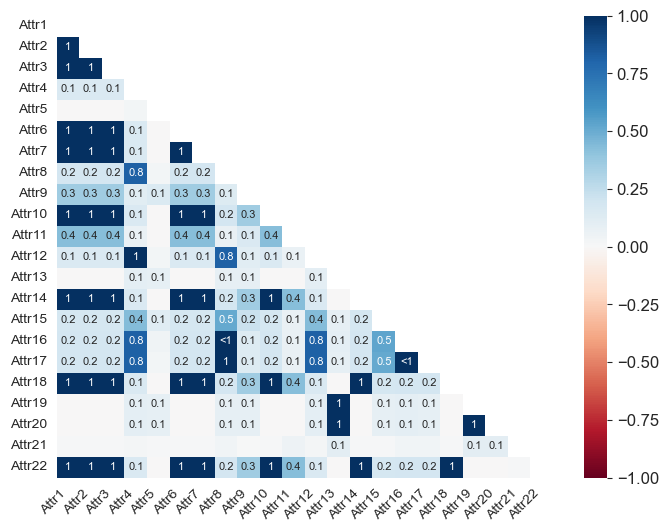

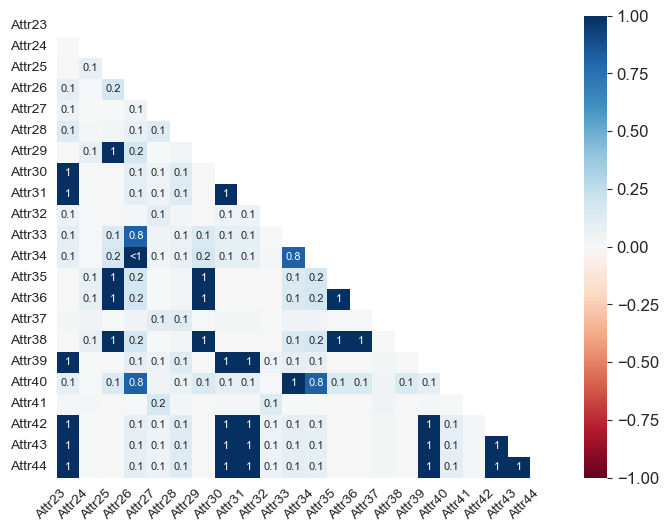

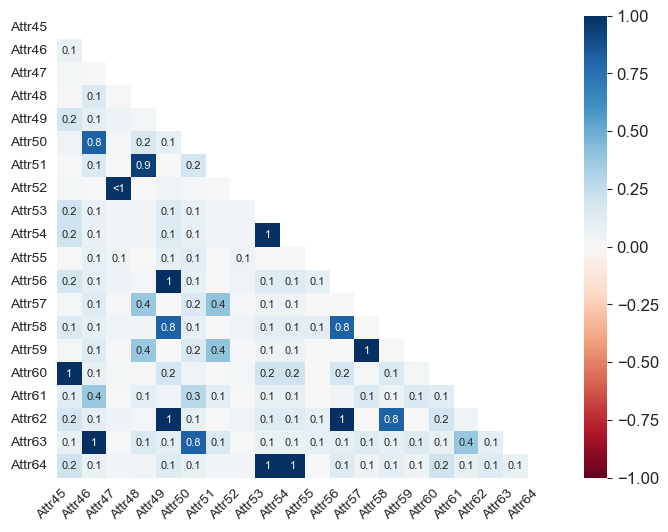

In [61]:
import missingno as msno
# Visualize missing data as a heatmap
msno.heatmap(combined_df.iloc[:, :23], fontsize=10, figsize=(8, 6))
# plt.savefig(f'plots/missing_heatmap.png')
plt.show()

msno.heatmap(combined_df.iloc[:,23:45], fontsize=10, figsize=(8, 6))
# plt.savefig(f'plots/missing_heatmap.png')
plt.show()

msno.heatmap(combined_df.iloc[:,45:], fontsize=10, figsize=(8, 6))
# plt.savefig(f'plots/missing_heatmap.png')
plt.show()

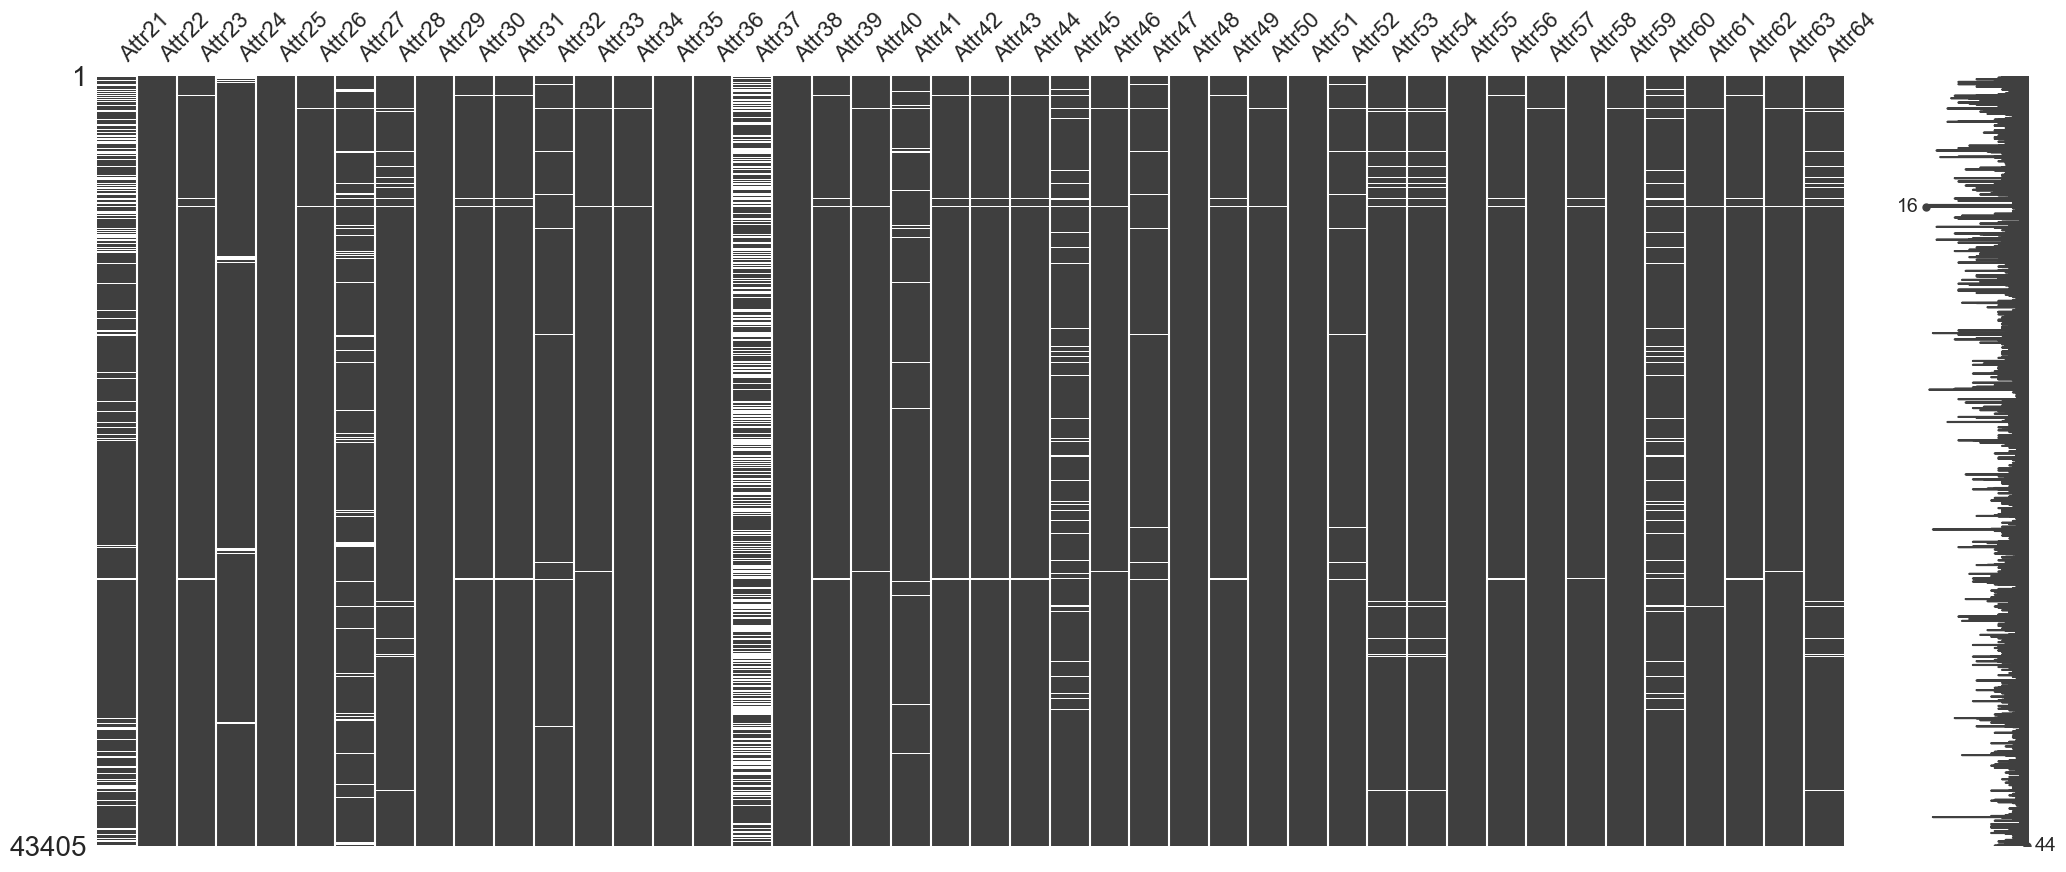

In [62]:
# Visualize missing data as a matrix
msno.matrix(combined_df.iloc[:,21:].loc[:, combined_df.isnull().any()])
# plt.savefig(f'plots/missing_matrix.png')
plt.show()


Missings above 0.5% start at 21:

37 - 43.7%  (Current assets – inventories) / long-term liabilities  
21 - 13.5%  Sales (n) / sales (n–1)

rows with consistent patterns:

28, 53, 54, 64 (same percentage missing 1.9%, 812 rows)

 - Working capital / fixed assets
 - Equity / fixed assets  
 - Constant capital / fixed assets
 - Sales / fixed assets

45, 60 (similar pattern, different percentages just under 5%)

  - Net profit / inventory
  - Sales / inventory 

32, 47, 52 (similar pattern, different percentages below 1%)

  - (Current liabilities × 365) / cost of products sold
  - (Inventory × 365) / cost of products sold
  - (Short-term liabilities × 365) / cost of products sold

other missings above 1% = 24, 27, 28, 41
  - Gross profit (in 3 years) / total assets
  - Profit on operating activities / financial expenses  
  - Working capital / fixed assets
  - Total liabilities / ((Profit on operating activities + depreciation) × (12/365))


### Plot the Distributions of Each Variable (bottom 95 percentile for histograms)

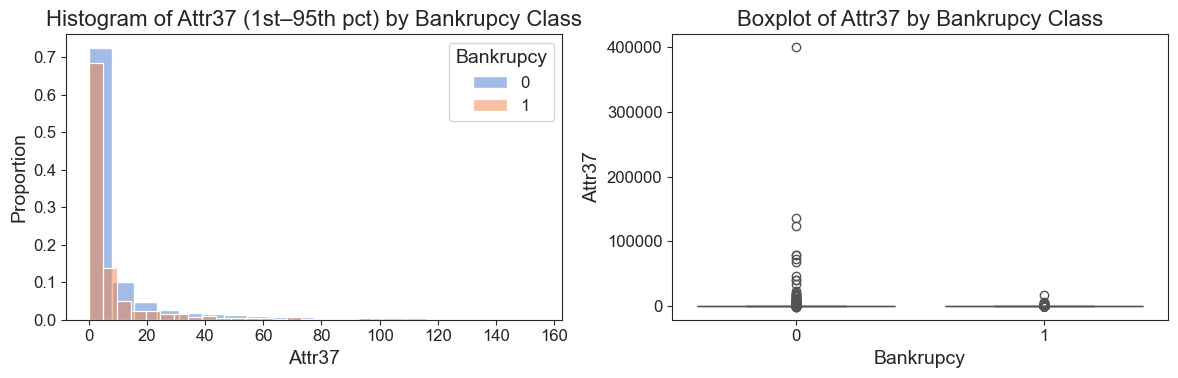

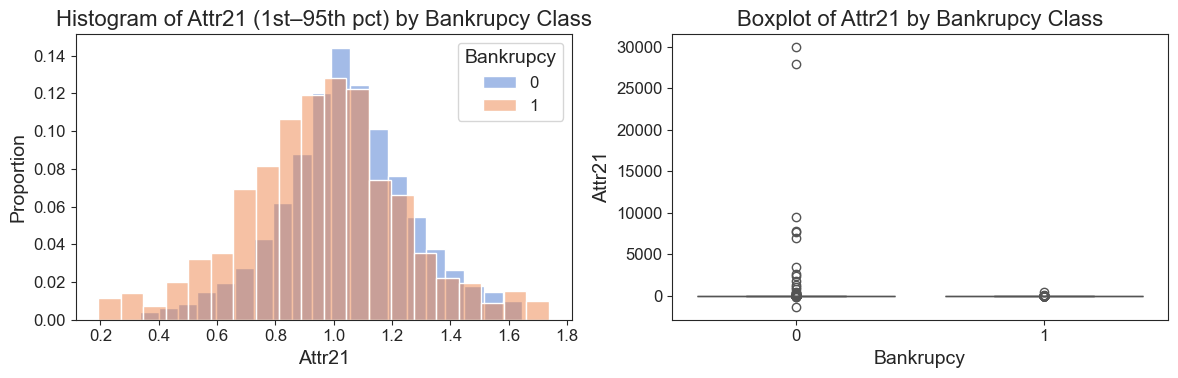

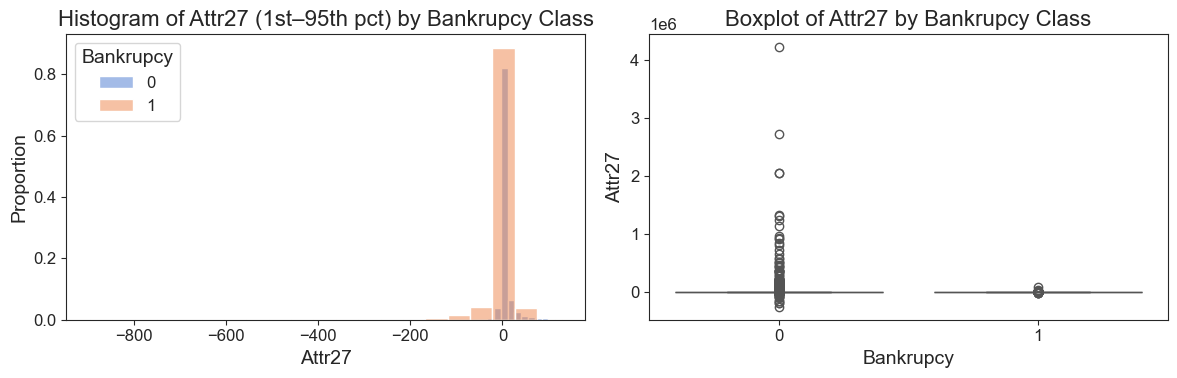

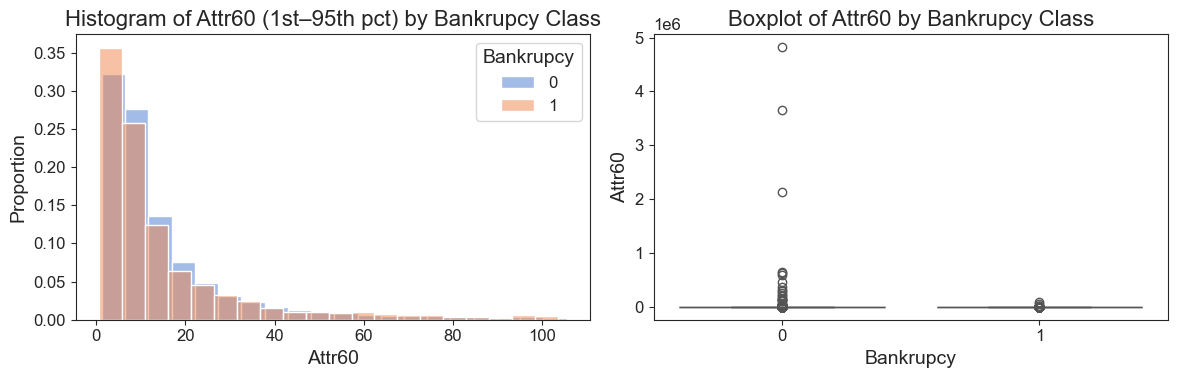

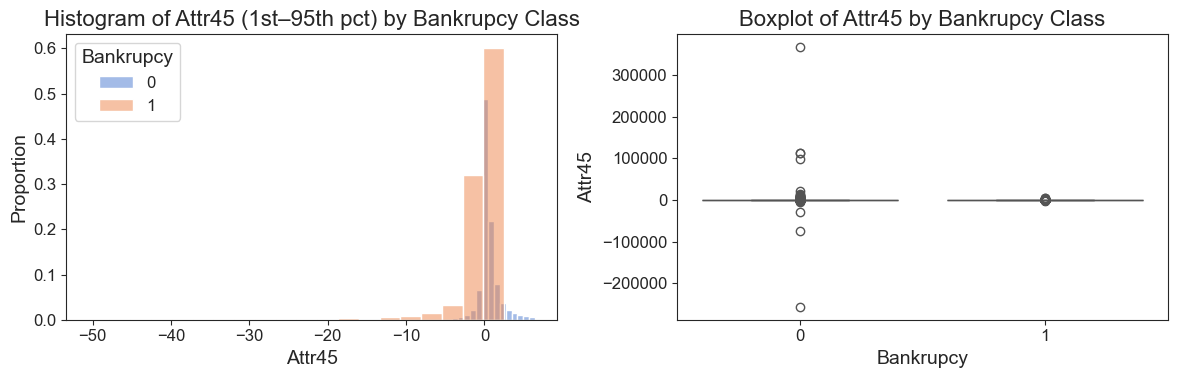

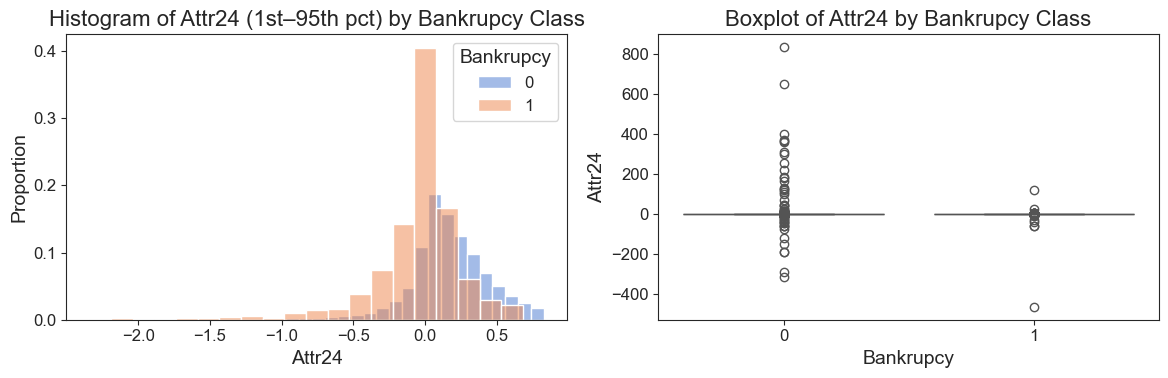

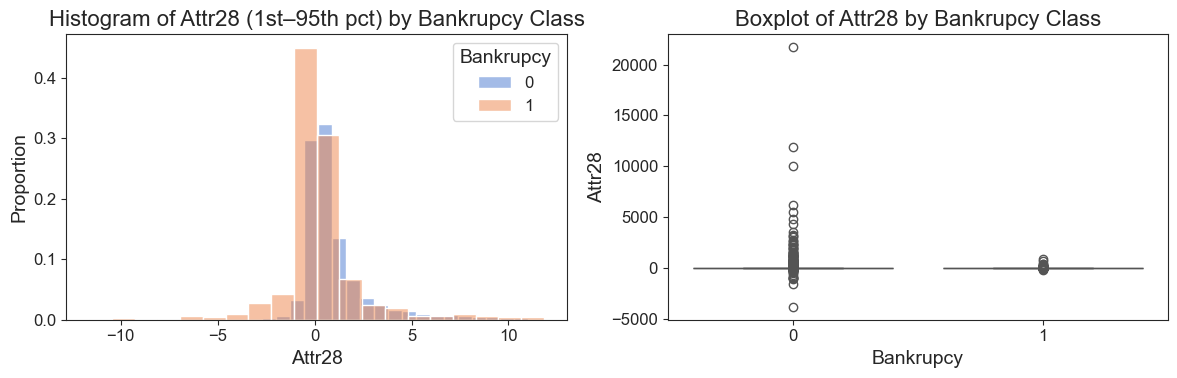

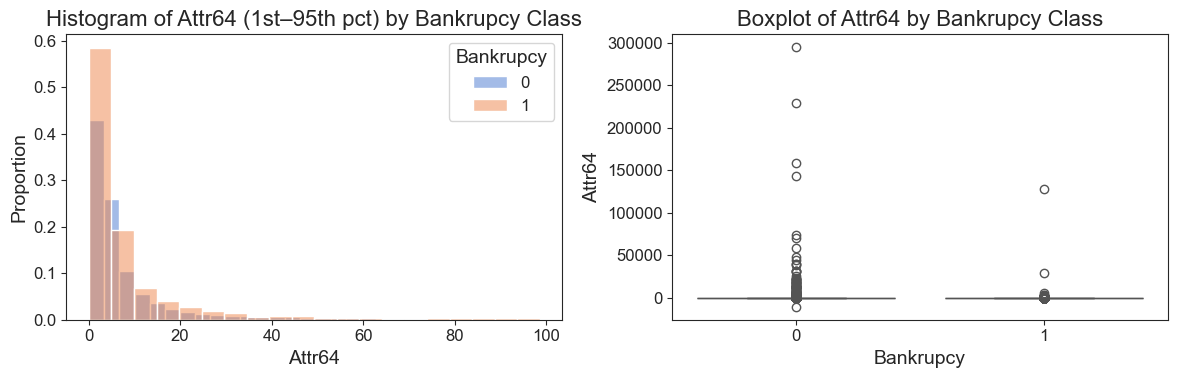

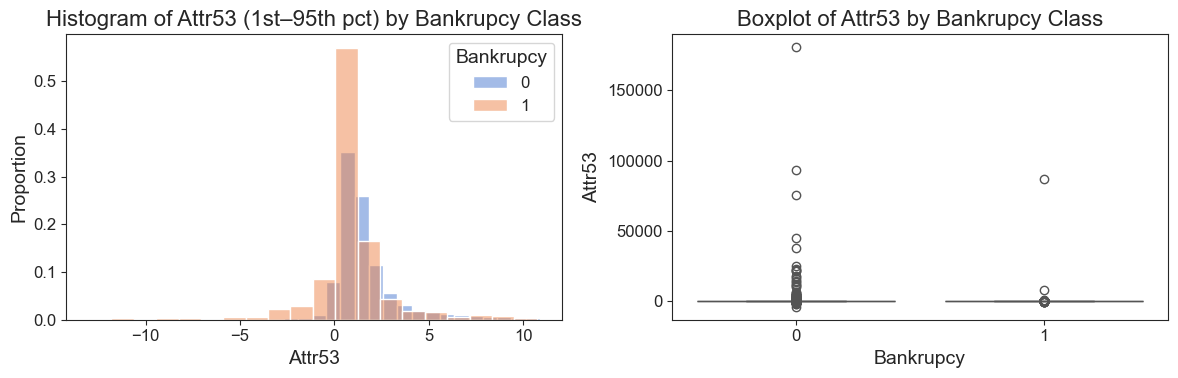

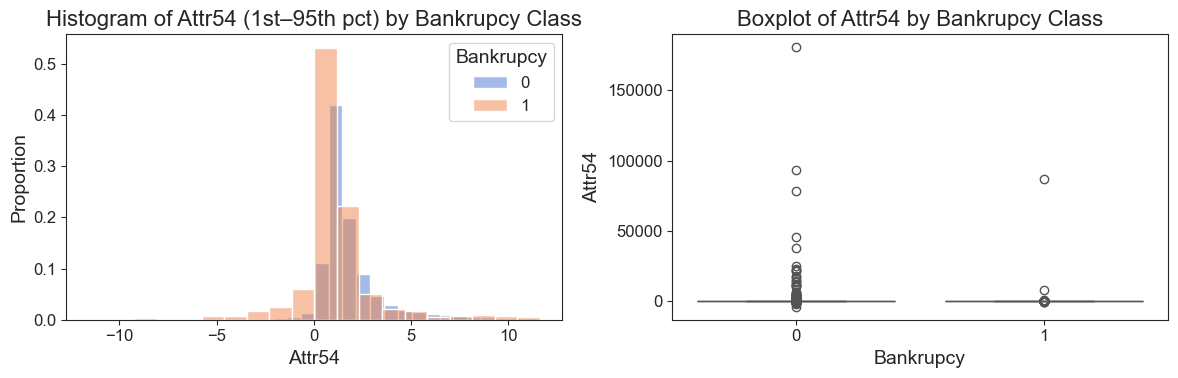

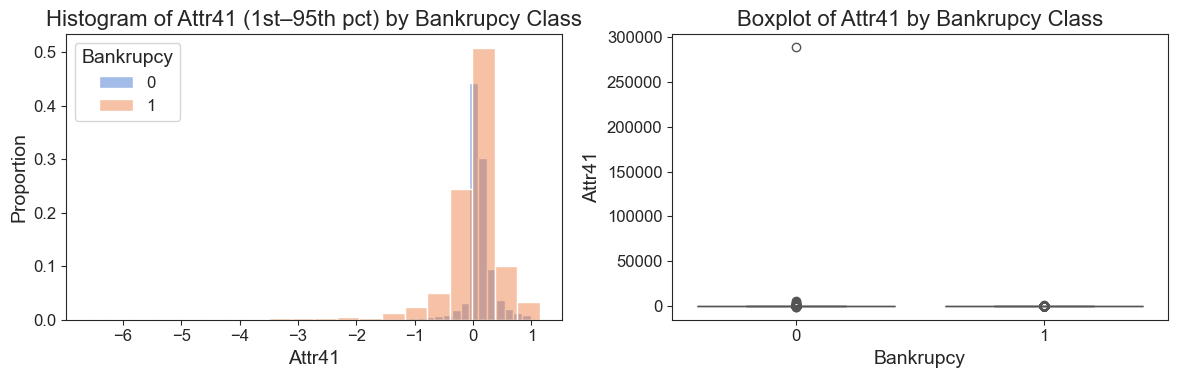

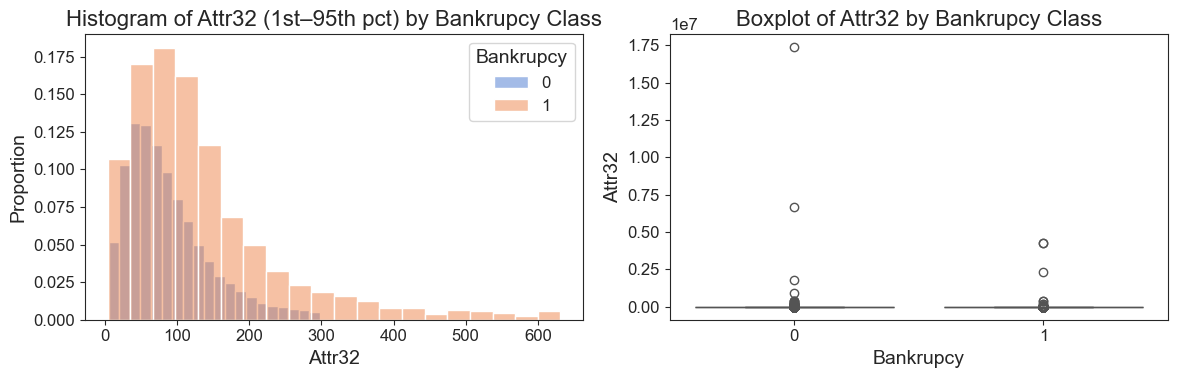

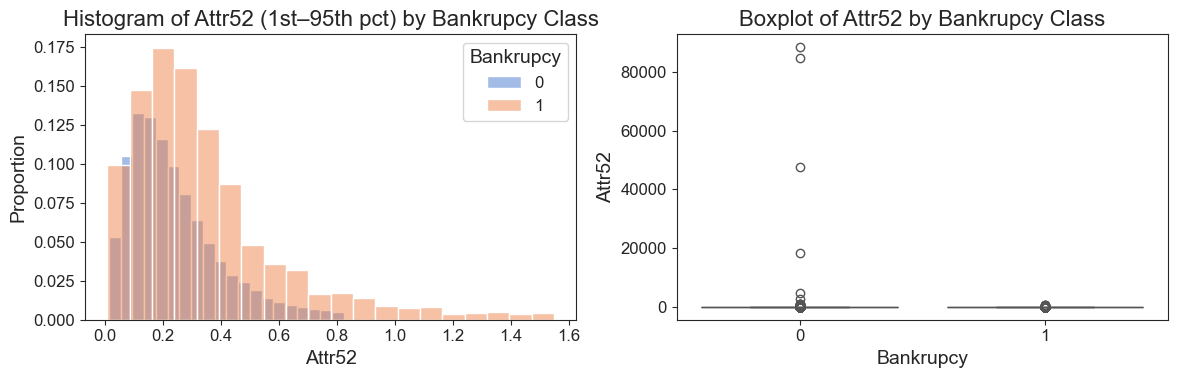

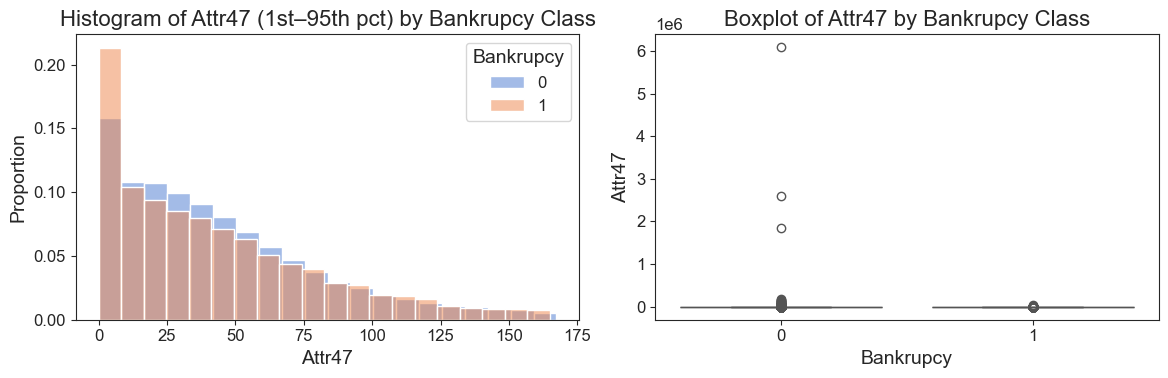

In [63]:
# List of numeric columns
numeric_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns

# Define target columns
selected_cols = nan_attrs_high

plot_only_selected = True
cols_to_plot = selected_cols if plot_only_selected else numeric_cols

# Set the color palette
classes = combined_df['class'].unique()
palette = sns.color_palette("muted", n_colors=len(classes))

# Generate plots for each numeric column
for col in cols_to_plot:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Histogram with proportions
    for idx, category in enumerate(classes):
        subset = combined_df[combined_df['class'] == category]

        # Clip to 1st–95th percentile
        lower = subset[col].quantile(0.01)
        upper = subset[col].quantile(0.95)
        clipped = subset[(subset[col] >= lower) & (subset[col] <= upper)]

        sns.histplot(clipped[col], bins=20, color=palette[idx], label=category,
                     alpha=0.5, stat="probability", ax=axes[0])

    axes[0].set_title(f"Histogram of {col} (1st–95th pct) by Bankrupcy Class")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Proportion')
    axes[0].legend(title='Bankrupcy')
    
    # OR Kernel Density Plot
    # for idx, category in enumerate(combined_df['class']):
    #     subset = combined_df[combined_df['class'] == category]
    #     sns.kdeplot(subset[col], fill=True, color=palette[idx], label=category, alpha=0.5, ax=axes[0])

    # axes[0].set_title(f"Kernel Density Plot of {col} by Bankrupcy Class")
    # axes[0].set_xlabel(col)
    # axes[0].set_ylabel('Density')
    # axes[0].legend(title='Bankrupcy')

    # Boxplot
    sns.boxplot(data=combined_df, x='class', y=col, hue='class', palette=palette[:len(classes)], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col} by Bankrupcy Class")
    axes[1].set_xlabel('Bankrupcy')
    axes[1].set_ylabel(col)
    
    plt.tight_layout()
    # plt.savefig(f'plots/plot_{col}_by_bankrupcy.png', bbox_inches="tight") 
    plt.show()

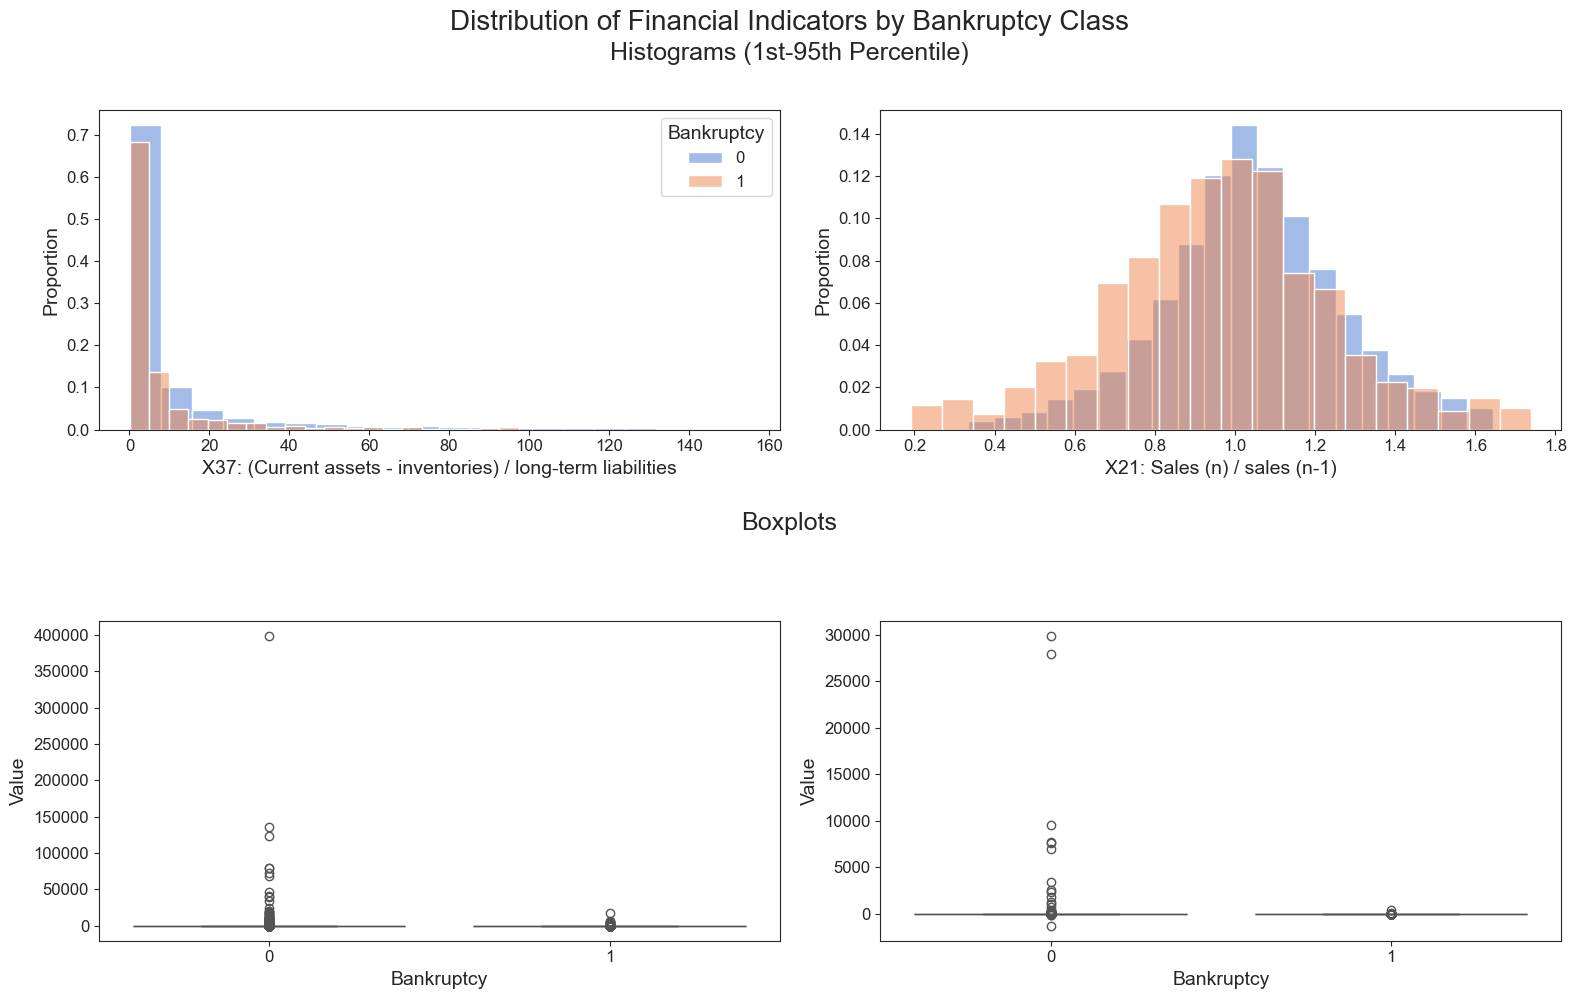

In [64]:
sns.set_style('ticks')

# Cols to plot with their descriptions
attr_info = {
    'Attr37': 'X37: (Current assets - inventories) / long-term liabilities',
    'Attr21': 'X21: Sales (n) / sales (n-1)'
}

# Set the color palette
classes = combined_df['class'].unique()
palette = sns.color_palette("muted", n_colors=len(classes))

# Set larger font sizes globally
plt.rcParams.update({
    'font.size': 14,          # Base font size
    'axes.titlesize': 16,     # Axes title
    'axes.labelsize': 14,     # Axes labels
    'xtick.labelsize': 12,    # X tick labels
    'ytick.labelsize': 12,    # Y tick labels
    'legend.fontsize': 12,    # Legend
})

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

# Row 0: Histograms for both attributes
# Row 1: Boxplots for both attributes
for col_idx, (col, label) in enumerate(attr_info.items()):
    # Histogram (top row)
    for class_idx, category in enumerate(classes):
        subset = combined_df[combined_df['class'] == category]
        
        # Clip to 1st–95th percentile
        lower = subset[col].quantile(0.01)
        upper = subset[col].quantile(0.95)
        clipped = subset[(subset[col] >= lower) & (subset[col] <= upper)]
        
        sns.histplot(clipped[col], bins=20, color=palette[class_idx], 
                     label=category, alpha=0.5, stat="probability", 
                     ax=axes[0, col_idx])
    
    axes[0, col_idx].set_xlabel(label, fontsize=14)
    if col_idx == 0:  # Only add legend to first histogram
        axes[0, col_idx].legend(title='Bankruptcy', fontsize=12, title_fontsize=14)
    
    # Boxplot (bottom row) - FIXED TO REMOVE WARNING
    sns.boxplot(data=combined_df, x='class', y=col, hue='class',
                palette=palette[:len(classes)], legend=False,
                ax=axes[1, col_idx])
    axes[1, col_idx].set_xlabel('Bankruptcy', fontsize=14)
    axes[1, col_idx].set_ylabel(label, fontsize=14)

# Add row titles
axes[0, 0].set_ylabel('Proportion', fontsize=14)
axes[0, 1].set_ylabel('Proportion', fontsize=14)
axes[1, 0].set_ylabel('Value', fontsize=14)
axes[1, 1].set_ylabel('Value', fontsize=14)

# Add row titles as text
fig.text(0.5, 0.95, 'Histograms (1st-95th Percentile)', ha='center', fontsize=18)
fig.text(0.5, 0.48, 'Boxplots', ha='center', fontsize=18)

# Add overall title
fig.suptitle('Distribution of Financial Indicators by Bankruptcy Class', 
             fontsize=20, y=1.0)

# Increase tick label size
for ax_row in axes:
    for ax in ax_row:
        ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.6)  # Adjust spacing for titles
plt.show()

### Impute Median Values by Year if <= 0.5% Missing

In [65]:
# Create a copy of the original combined DataFrame
imputed_df = combined_df.copy()

# Impute NaNs in columns with <= 0.5% NaN with median within each year
for col in nan_attrs_low:
    imputed_df[col] = imputed_df.groupby('year')[col].transform(lambda x: x.fillna(x.median()))

# Sanity check
print(imputed_df[nan_attrs_low].isna().sum())

Attr46    0
Attr40    0
Attr63    0
Attr33    0
Attr4     0
Attr12    0
Attr19    0
Attr31    0
Attr62    0
Attr56    0
Attr49    0
Attr44    0
Attr43    0
Attr20    0
Attr39    0
Attr13    0
Attr42    0
Attr30    0
Attr23    0
Attr61    0
Attr16    0
Attr26    0
Attr34    0
Attr50    0
Attr17    0
Attr8     0
Attr5     0
Attr58    0
Attr11    0
Attr15    0
Attr9     0
Attr48    0
Attr7     0
Attr22    0
Attr18    0
Attr3     0
Attr6     0
Attr14    0
Attr51    0
Attr2     0
Attr10    0
Attr25    0
Attr29    0
Attr38    0
Attr36    0
Attr35    0
Attr1     0
Attr57    0
Attr59    0
Attr55    0
dtype: int64


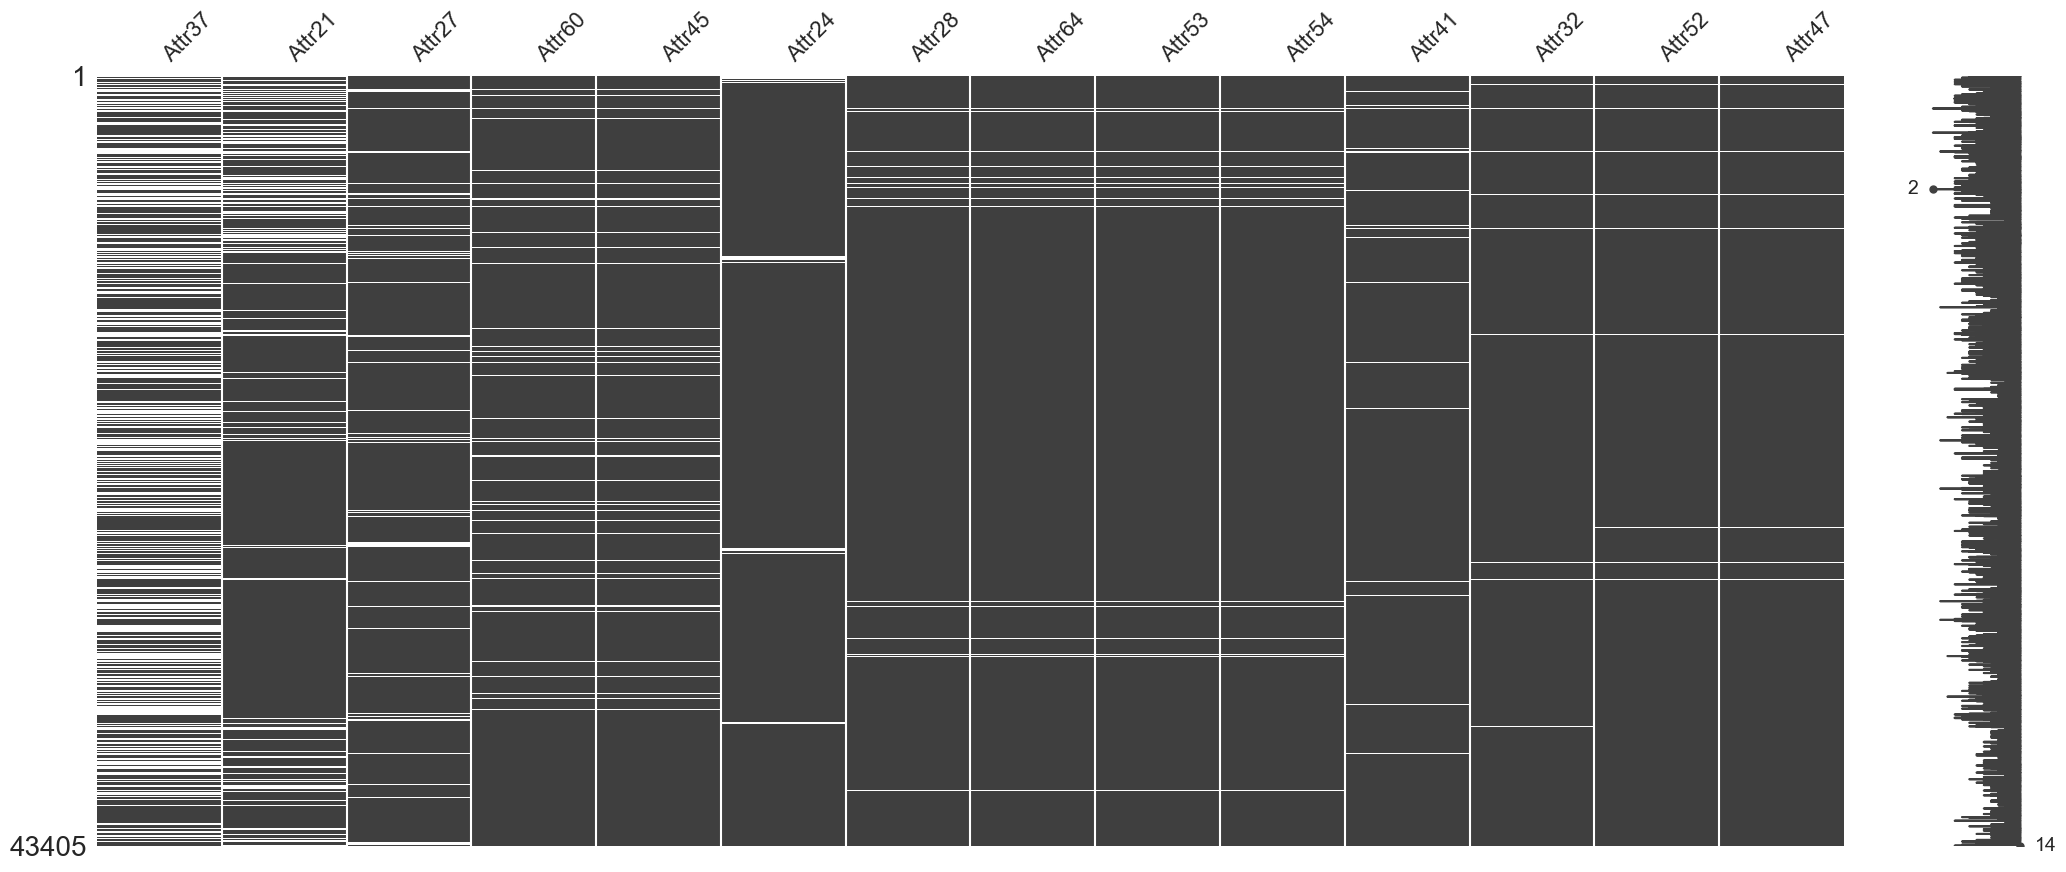

In [66]:
msno.matrix(combined_df[nan_attrs_high])
plt.show()

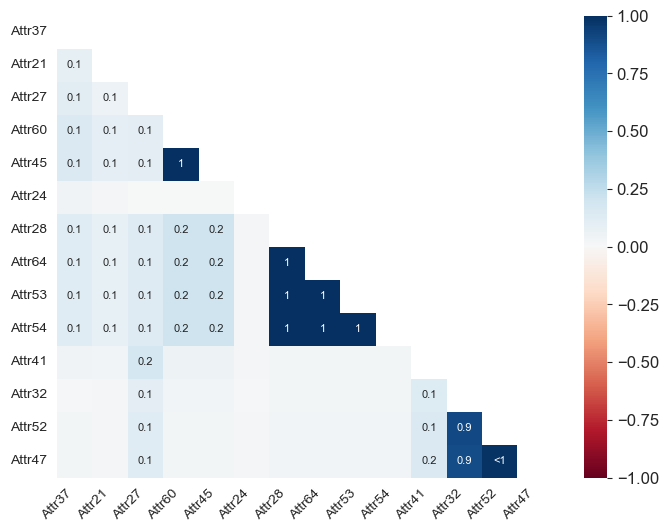

In [67]:
msno.heatmap(combined_df[nan_attrs_high], fontsize=10, figsize=(8, 6))
plt.show()

### Impute Attr28 with Median Values by Year

The missing values are perfectly correlated with Attrs 53, 54, and 64 because they all are over fixed assets. If I impute this, I can calculate fixed assets and then recover many missing values by calculation rather than median imputation. 

In [68]:
# Impute NaNs in 'Attr28' with median within each year
imputed_df['Attr28'] = imputed_df.groupby('year')['Attr28'].transform(lambda x: x.fillna(x.median()))

# Sanity check
print(imputed_df['Attr28'].isna().sum())

0


### Examine Missing Values that Can be Calculated 

Variable that we can calculate from:
- X55: Working capital

Can calculate:

- **Total assets** from X3 = working capital / total assets, so total assets = X55/X3.
- **Fixed assets** from X28 = working capital / fixed assets, so fixed assets = X55/X28.
- **Equity** from X10 = equity / total assets, so equity = X10 * total assets
- **Constant capital** from X38	= constant capital / total assets, so contant capital = X38 * total assets
- **Sales** from X9	= sales / total assets, so sales = X9 * total assets
- **Net profit** from X1 = net profit / total assets, so net profit = X1 * total assets
- **Inventory** from X20 = (inventory * 365) / sales, so inventory = (X20 * sales) / 365
- **Cost of products sold** from X56 = (sales - cost of products sold) / sales, so cost of products sold = sales - (X56 * sales)
- **Short-term liabilities** from X51 = short-term liabilities / total assets, so short-term liabilities = X51 * total assets
- **Gross profit** from X18	= gross profit / total assets, so gross profit = X18 * total assets
- **Depreciation** from X13	= (gross profit + depreciation) / sales, so depreciation = (X13 * sales) - gross profit
- **Profit on operating activities** from X22 = profit on operating activities / total assets, so profit on operating activities = X22 * total assets
- **Total liabilities** from X2 = total liabilities / total assets, so total liabilities = X2 * total assets

Can then impute:

- 53 with Equity / fixed assets
- 54 with Constant capital / fixed assets
- 64 with Sales / fixed assets
- 45 with Net profit / inventory
- 60 with Sales / inventory 
- 47 with (Inventory × 365) / cost of products sold
- 52 with (Short-term liabilities × 365) / cost of products sold
- 41 with Total liabilities / ((Profit on operating activities + depreciation) × (12/365))

Missings above 0.5% start at 21:  
37 - 43.7%  (Current assets – inventories) / long-term liabilities **not sure if inventories is related to inventory**  
21 - 13.5%  Sales (n) / sales (n–1) **not sure what n is**. 

Rows with consistent patterns:

- 28, 53, 54, 64 (same percentage missing 1.9%, 812 rows)
  - Working capital / fixed assets
  - Equity / fixed assets  
  - Constant capital / fixed assets
  - Sales / fixed assets

- 45, 60 (similar pattern, different percentages just under 5%)
  - Net profit / inventory
  - Sales / inventory 

- 32, 47, 52 (similar pattern, different percentages below 1%)
  - (Current liabilities × 365) / cost of products sold **can't easily compute**
  - (Inventory × 365) / cost of products sold
  - (Short-term liabilities × 365) / cost of products sold

Other missings above 1% = 24, 27, 41:

- Gross profit (in 3 years) / total assets **not sure if related to Gross profit / total assets**
- Profit on operating activities / financial expenses **can't easily compute**
- Total liabilities / ((Profit on operating activities + depreciation) × (12/365))

### Calculate Component Variables

In [69]:
def check_missing_and_zero_div(df, target, inputs, divisor=None):
    """
    Check missingness of inputs and optionally zero-divisors for derived calculations.
    
    Args:
        df: DataFrame
        target: the name of the column you're calculating
        inputs: list of columns used in the calculation
        divisor: if specified, column name that is used as the divisor
    """
    print(f"\n{target}")
    print(f"Total NaNs in {target}: {df[target].isna().sum()}")
    
    for col in inputs:
        print(f"  {col}: {df[col].isna().sum()} NaNs")
    
    if divisor:
        zero_count = (df[divisor] == 0).sum()
        zero_and_non_missing = ((df[divisor] == 0) & df[divisor].notna()).sum()
        print(f"  {divisor} = 0 in {zero_count} rows (non-missing: {zero_and_non_missing})")
    
    valid_inputs = df[inputs].notna().all(axis=1)
    unexplained_nans = df[target].isna() & valid_inputs
    print(f"  Rows where all inputs are present but {target} is still NaN: {unexplained_nans.sum()}")


# Example usage with your calculations

imputed_df['Total_assets'] = imputed_df['Attr55'] / imputed_df['Attr3']
check_missing_and_zero_div(imputed_df, 'Total_assets', ['Attr55', 'Attr3'], divisor='Attr3')

imputed_df['Fixed_assets'] = imputed_df['Attr55'] / imputed_df['Attr28']
check_missing_and_zero_div(imputed_df, 'Fixed_assets', ['Attr55', 'Attr28'], divisor='Attr28')

imputed_df['Equity'] = imputed_df['Attr10'] * imputed_df['Total_assets']
check_missing_and_zero_div(imputed_df, 'Equity', ['Attr10', 'Total_assets'])

imputed_df['Constant_capital'] = imputed_df['Attr38'] * imputed_df['Total_assets']
check_missing_and_zero_div(imputed_df, 'Constant_capital', ['Attr38', 'Total_assets'])

imputed_df['Sales'] = imputed_df['Attr9'] * imputed_df['Total_assets']
check_missing_and_zero_div(imputed_df, 'Sales', ['Attr9', 'Total_assets'])

imputed_df['Net_profit'] = imputed_df['Attr1'] * imputed_df['Total_assets']
check_missing_and_zero_div(imputed_df, 'Net_profit', ['Attr1', 'Total_assets'])

imputed_df['Inventory'] = (imputed_df['Attr20'] * imputed_df['Sales']) / 365
check_missing_and_zero_div(imputed_df, 'Inventory', ['Attr20', 'Sales'], divisor='Sales')

imputed_df['Cost_of_products_sold'] = imputed_df['Sales'] - (imputed_df['Attr56'] * imputed_df['Sales'])
check_missing_and_zero_div(imputed_df, 'Cost_of_products_sold', ['Attr56', 'Sales'])

imputed_df['Short-term_liabilities'] = imputed_df['Attr51'] * imputed_df['Total_assets']
check_missing_and_zero_div(imputed_df, 'Short-term_liabilities', ['Attr51', 'Total_assets'])

imputed_df['Gross_profit'] = imputed_df['Attr18'] * imputed_df['Total_assets']
check_missing_and_zero_div(imputed_df, 'Gross_profit', ['Attr18', 'Total_assets'])

imputed_df['Depreciation'] = (imputed_df['Attr13'] * imputed_df['Sales']) - imputed_df['Gross_profit']
check_missing_and_zero_div(imputed_df, 'Depreciation', ['Attr13', 'Sales', 'Gross_profit'])

imputed_df['Profit_on_operating_activities'] = imputed_df['Attr22'] * imputed_df['Total_assets']
check_missing_and_zero_div(imputed_df, 'Profit_on_operating_activities', ['Attr22', 'Total_assets'])

imputed_df['Total_liabilities'] = imputed_df['Attr2'] * imputed_df['Total_assets']
check_missing_and_zero_div(imputed_df, 'Total_liabilities', ['Attr2', 'Total_assets'])



Total_assets
Total NaNs in Total_assets: 24
  Attr55: 0 NaNs
  Attr3: 0 NaNs
  Attr3 = 0 in 24 rows (non-missing: 24)
  Rows where all inputs are present but Total_assets is still NaN: 24

Fixed_assets
Total NaNs in Fixed_assets: 22
  Attr55: 0 NaNs
  Attr28: 0 NaNs
  Attr28 = 0 in 22 rows (non-missing: 22)
  Rows where all inputs are present but Fixed_assets is still NaN: 22

Equity
Total NaNs in Equity: 24
  Attr10: 0 NaNs
  Total_assets: 24 NaNs
  Rows where all inputs are present but Equity is still NaN: 0

Constant_capital
Total NaNs in Constant_capital: 24
  Attr38: 0 NaNs
  Total_assets: 24 NaNs
  Rows where all inputs are present but Constant_capital is still NaN: 0

Sales
Total NaNs in Sales: 24
  Attr9: 0 NaNs
  Total_assets: 24 NaNs
  Rows where all inputs are present but Sales is still NaN: 0

Net_profit
Total NaNs in Net_profit: 24
  Attr1: 0 NaNs
  Total_assets: 24 NaNs
  Rows where all inputs are present but Net_profit is still NaN: 0

Inventory
Total NaNs in Inventory:

### Impute with Calculated Values

In [70]:
# Impupte 53 with Equity / fixed assets
mask = imputed_df['Attr53'].isna() & imputed_df['Equity'].notna() & imputed_df['Fixed_assets'].notna()
idx = imputed_df[mask].index  # <-- Extract the row indices where the mask is True
imputed_df.loc[idx, 'Attr53'] = imputed_df.loc[idx, 'Equity'] / imputed_df.loc[idx, 'Fixed_assets']

# Impute 54 with Constant capital / fixed assets
mask = imputed_df['Attr54'].isna() & imputed_df['Constant_capital'].notna() & imputed_df['Fixed_assets'].notna()
idx = imputed_df[mask].index
imputed_df.loc[idx, 'Attr54'] = imputed_df.loc[idx, 'Constant_capital'] / imputed_df.loc[idx, 'Fixed_assets']

# Impute 64 with Sales / fixed assets
mask = imputed_df['Attr64'].isna() & imputed_df['Sales'].notna() & imputed_df['Fixed_assets'].notna()
idx = imputed_df[mask].index
imputed_df.loc[idx, 'Attr64'] = imputed_df.loc[idx, 'Sales'] / imputed_df.loc[idx, 'Fixed_assets']

# Impute 45 with Net profit / inventory
mask = imputed_df['Attr45'].isna() & imputed_df['Net_profit'].notna() & imputed_df['Inventory'].notna()
idx = imputed_df[mask].index
imputed_df.loc[idx, 'Attr45'] = imputed_df.loc[idx, 'Net_profit'] / imputed_df.loc[idx, 'Inventory']

# Impute 60 with Sales / inventory
mask = imputed_df['Attr60'].isna() & imputed_df['Sales'].notna() & imputed_df['Inventory'].notna()
idx = imputed_df[mask].index
imputed_df.loc[idx, 'Attr60'] = imputed_df.loc[idx, 'Sales'] / imputed_df.loc[idx, 'Inventory']

# Impute 47 with (Inventory × 365) / cost of products sold
mask = imputed_df['Attr47'].isna() & imputed_df['Inventory'].notna() & imputed_df['Cost_of_products_sold'].notna()
idx = imputed_df[mask].index
imputed_df.loc[idx, 'Attr47'] = (imputed_df.loc[idx, 'Inventory'] * 365) / imputed_df.loc[idx, 'Cost_of_products_sold']

# Impute 52 with (Short-term liabilities × 365) / cost of products sold
mask = imputed_df['Attr52'].isna() & imputed_df['Short-term_liabilities'].notna() & imputed_df['Cost_of_products_sold'].notna()
idx = imputed_df[mask].index
imputed_df.loc[idx, 'Attr52'] = (imputed_df.loc[idx, 'Short-term_liabilities'] * 365) / imputed_df.loc[idx, 'Cost_of_products_sold']

# Impute 41 with Total liabilities / ((Profit on operating activities + depreciation) × (12/365))
mask = imputed_df['Attr41'].isna() & imputed_df['Total_liabilities'].notna() & imputed_df['Profit_on_operating_activities'].notna() & imputed_df['Depreciation'].notna()
idx = imputed_df[mask].index
imputed_df.loc[idx, 'Attr41'] = imputed_df.loc[idx, 'Total_liabilities'] / ((imputed_df.loc[idx, 'Profit_on_operating_activities'] + imputed_df.loc[idx, 'Depreciation']) * (12/365)) 
                               

### Re-examine Missings

In [71]:
# Find remaining NaNs in the dataset
nan_sums = imputed_df.isna().sum()
nan_sums_nonzero = nan_sums[nan_sums != 0]
nan_sums_nonzero

# Calculate percentages
nan_percentages = (nan_sums_nonzero / len(combined_df)) * 100

# Create a DataFrame of NaN counts and percentages
nan_summary = pd.DataFrame({
    'NaN Count': nan_sums_nonzero,
    'NaN Percentage': nan_percentages
}).sort_values(by='NaN Count', ascending=False)

print(nan_summary)
# print(nan_summary[nan_summary['NaN Percentage'] >= 0.5])

                                NaN Count  NaN Percentage
Attr37                              18984       43.736897
Attr21                               5854       13.486925
Attr27                               2764        6.367930
Attr24                                922        2.124179
Attr32                                368        0.847829
Attr60                                104        0.239604
Attr47                                 40        0.092155
Constant_capital                       24        0.055293
Profit_on_operating_activities         24        0.055293
Depreciation                           24        0.055293
Gross_profit                           24        0.055293
Short-term_liabilities                 24        0.055293
Cost_of_products_sold                  24        0.055293
Inventory                              24        0.055293
Net_profit                             24        0.055293
Sales                                  24        0.055293
Total_assets  

In [72]:
# Limit to numeric columns first
numeric_df = imputed_df.select_dtypes(include=[np.number])

# Count NaNs per column (all columns)
nan_sums = imputed_df.isna().sum()

# Count infs only for numeric columns
inf_sums = np.isinf(numeric_df).sum()

# Align nan_sums to same numeric subset (optional: for a pure numeric summary)
nan_sums_numeric = nan_sums[numeric_df.columns]

# Filter to columns with either NaNs or infs
affected_columns = (nan_sums_numeric + inf_sums) != 0
nan_sums_filtered = nan_sums_numeric[affected_columns]
inf_sums_filtered = inf_sums[affected_columns]

# Compute percentages
total_rows = len(imputed_df)
nan_percentages = (nan_sums_filtered / total_rows) * 100
inf_percentages = (inf_sums_filtered / total_rows) * 100

# Combine into summary DataFrame
missing_summary = pd.DataFrame({
    'NaN Count': nan_sums_filtered,
    'NaN Percentage': nan_percentages,
    'Inf Count': inf_sums_filtered,
    'Inf Percentage': inf_percentages
}).sort_values(by=['NaN Count', 'Inf Count'], ascending=False)

missing_summary

,NaN Count,NaN Percentage,Inf Count,Inf Percentage
Attr37,18984,43.736897,0,0.000000
Attr21,5854,13.486925,0,0.000000
Attr27,2764,6.367930,0,0.000000
Attr24,922,2.124179,0,0.000000
Attr32,368,0.847829,0,0.000000
Attr60,104,0.239604,2048,4.718350
Attr47,40,0.092155,254,0.585186
Total_assets,24,0.055293,0,0.000000
Equity,24,0.055293,0,0.000000
Constant_capital,24,0.055293,0,0.000000


In [73]:
# Replace infinites (from division by zero probably) with NaNs for imputation
imputed_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check for any remaining inf values
print(np.isinf(imputed_df.select_dtypes(include=[np.number])).sum().sum())  # Should be 0


0


In [74]:
# Compute correlation matrix
corr_matrix = imputed_df.corr(numeric_only=True)

# Reset index and unstack
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # upper triangle, no self-corrs
corr_pairs = corr_pairs.stack().reset_index()
corr_pairs.columns = ['Var1', 'Var2', 'Correlation']

# Find perfectly correlated (±1.0) — allowing tiny floating point wiggle room
perfect_corr_df = corr_pairs[np.isclose(corr_pairs['Correlation'].abs(), 1.0)]

print(perfect_corr_df)

# Find correlations ≥ 0.99 (or ≤ -0.99)
high_corr_df = corr_pairs[corr_pairs['Correlation'].abs() >= 0.99]
high_corr_df = high_corr_df.sort_values(by='Correlation', key=np.abs, ascending=False)

print(high_corr_df)


      Var1    Var2  Correlation
524  Attr7  Attr14          1.0
            Var1              Var2  Correlation
524        Attr7            Attr14     1.000000
343        Attr4            Attr46     0.999920
1385      Attr20            Attr56    -0.999880
596        Attr8            Attr17     0.999588
1295      Attr19            Attr23     0.999290
1303      Attr19            Attr31     0.999201
2408      Attr43            Attr44     0.999132
752       Attr10            Attr38     0.998974
2703      Attr53            Attr54     0.998696
1525      Attr23            Attr31     0.998492
275        Attr3            Attr51    -0.998219
2773      Attr56            Attr58    -0.998218
1387      Attr20            Attr58     0.998136
2978  Net_profit      Gross_profit     0.997477
990       Attr14            Attr18     0.995721
528        Attr7            Attr18     0.995703
683        Attr9            Attr36     0.995088
2948      Equity  Constant_capital     0.994110
2420      Attr43        

Variables 7 and 14 are essentially perfectly correlated.

- X7 = EBIT / total assets
- X14 = (gross profit + interest) / total assets

Checking the other highly correlated variables with the variables will missing values, the only other nearly perfectly correlated (99.87%) variables are 53 and 54. 

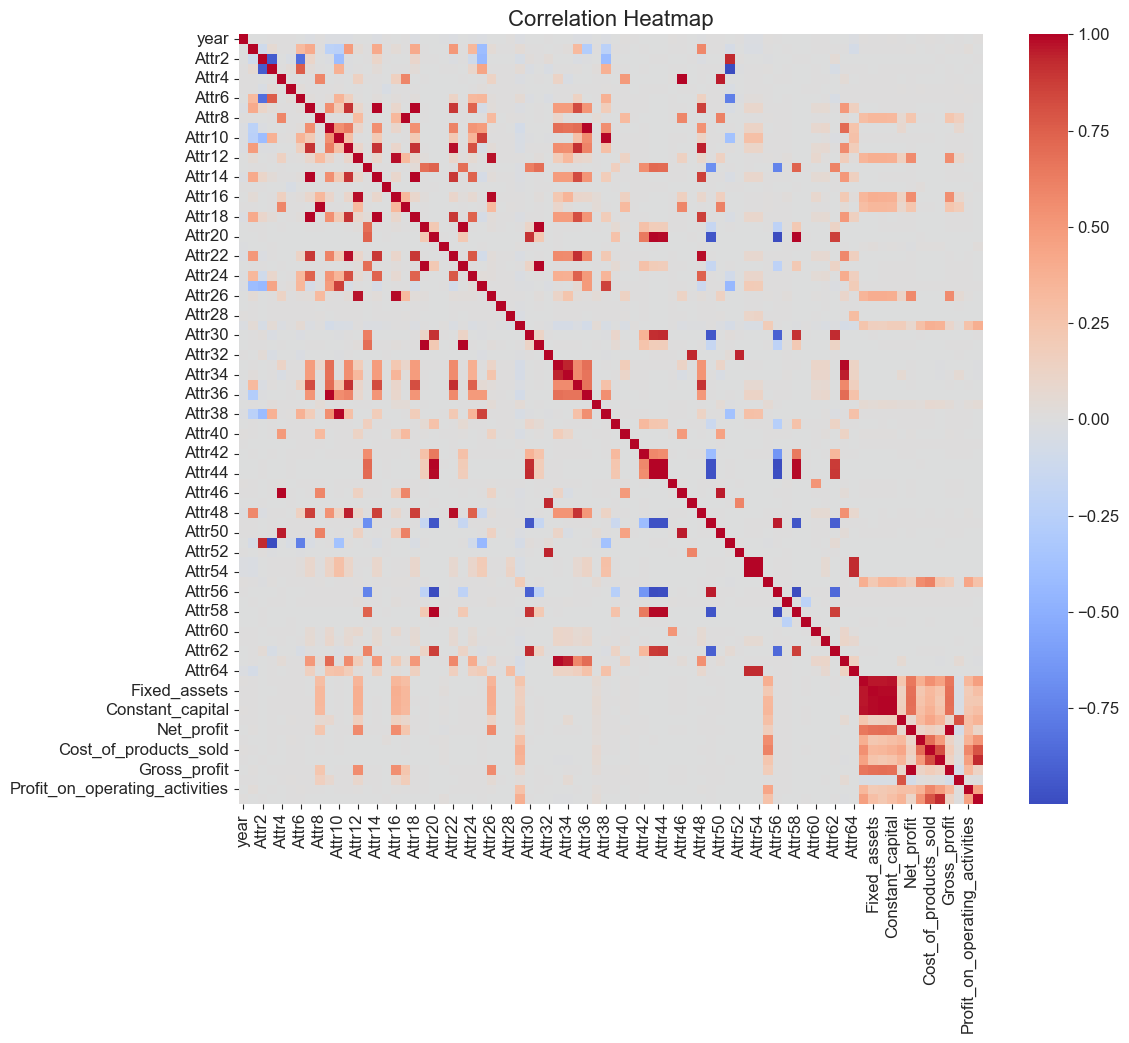

In [75]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap")
plt.show()


Attr 37, 21, and 27 don't appear correlated with any variables!

### Impute Remaining Values with Median Values by Year

In [76]:
imputed_df.columns

Index(['year', 'Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7',
       'Attr8', 'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14',
       'Attr15', 'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21',
       'Attr22', 'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28',
       'Attr29', 'Attr30', 'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35',
       'Attr36', 'Attr37', 'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42',
       'Attr43', 'Attr44', 'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49',
       'Attr50', 'Attr51', 'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56',
       'Attr57', 'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63',
       'Attr64', 'class', 'Total_assets', 'Fixed_assets', 'Equity',
       'Constant_capital', 'Sales', 'Net_profit', 'Inventory',
       'Cost_of_products_sold', 'Short-term_liabilities', 'Gross_profit',
       'Depreciation', 'Profit_on_operating_activities', 'Total_liabilities'],
      dtype='object')

In [77]:
# List of columns to impute (excluding 'year')
cols_to_impute = [col for col in imputed_df.columns if col.startswith('Attr')]

# Impute and print each column
for col in cols_to_impute:
    missing_before = imputed_df[col].isna().sum()
    imputed_df[col] = imputed_df.groupby('year')[col].transform(lambda x: x.fillna(x.median()))
    missing_after = imputed_df[col].isna().sum()
    filled = missing_before - missing_after
    if filled > 0:
        print(f"{col}: filled {filled} missing values")


Attr21: filled 5854 missing values
Attr24: filled 922 missing values
Attr27: filled 2764 missing values
Attr32: filled 368 missing values
Attr37: filled 18984 missing values
Attr41: filled 4 missing values
Attr45: filled 2147 missing values
Attr47: filled 294 missing values
Attr52: filled 298 missing values
Attr53: filled 4 missing values
Attr54: filled 4 missing values
Attr60: filled 2152 missing values
Attr64: filled 4 missing values


### Are the Bankruptcy Classes Imbalanced?

In [78]:
# Find the proportion of each response class
print(combined_df['class'].value_counts()/combined_df['class'].count())

class
0    0.951826
1    0.048174
Name: count, dtype: float64


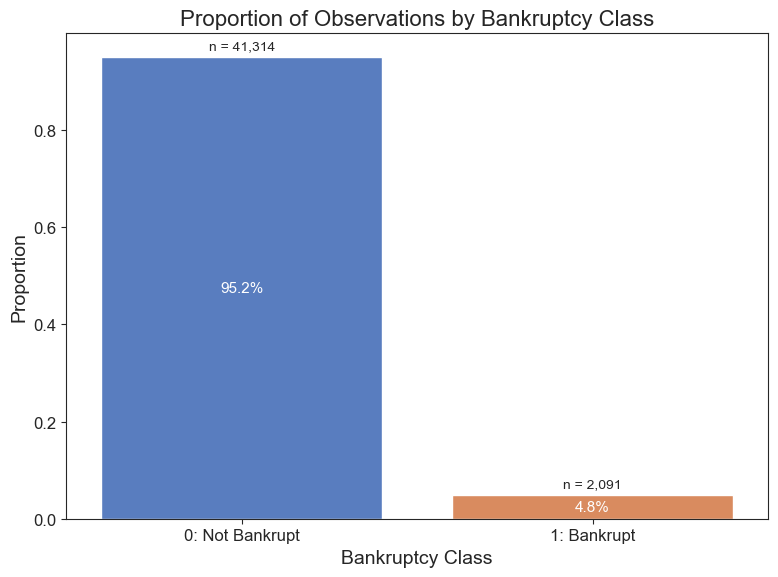

In [79]:
# Set the color palette
palette = sns.color_palette("muted", n_colors=len(combined_df['class'].unique()))
labels = {
    '0': '0: Not Bankrupt',
    '1': '1: Bankrupt'
}

# Calculate counts and proportions of each category
class_counts = combined_df['class'].value_counts(sort=False)  # Counts
class_proportions = class_counts / class_counts.sum()  # Proportions

# Create a DataFrame for plotting with proper labels
plot_df = pd.DataFrame({
    'class_label': [labels[i] for i in class_counts.index],
    'proportion': class_proportions.values,
    'count': class_counts.values
})

# Plot the distribution
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    x='class_label',
    y='proportion', 
    data=plot_df,
    palette=palette, 
    hue='class_label',
    ax=ax
)

# Remove the legend (redundant with x-axis labels)
ax.get_legend().remove() if ax.get_legend() else None

# Add titles and labels
ax.set_title('Proportion of Observations by Bankruptcy Class')
ax.set_xlabel('Bankruptcy Class')
ax.set_ylabel('Proportion')

# Add counts as labels on top of each bar
for i, (bar, count) in enumerate(zip(ax.patches, plot_df['count'])):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate
        bar.get_height() + 0.01,           # y-coordinate (slightly above bar)
        f'n = {count:,}',                  # Text label with formatting
        ha='center', va='bottom',          # Center alignment
        fontsize=10
    )
    
    # Add percentage inside or on top of the bar
    percentage = plot_df['proportion'].iloc[i] * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate
        bar.get_height() / 2,              # y-coordinate (middle of bar)
        f'{percentage:.1f}%',              # Text label with formatting
        ha='center', va='center',          # Center alignment
        fontsize=11,
        color='white' # if percentage < 90 else 'black'  # Make text visible
    )

plt.tight_layout()
plt.show()

### Modeling

#### Split the data into X and y

In [80]:
# Split features (X) and target (y) from imputed_df
X = imputed_df.iloc[:, 1:65]
X = X.drop(columns = 'Attr14') # drop Attr14, perfectly correlated with Attr 7
print(X.columns)
y = imputed_df['class']
print(y)
y = y.astype(int)
print(y.unique())

Index(['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8',
       'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr15', 'Attr16',
       'Attr17', 'Attr18', 'Attr19', 'Attr20', 'Attr21', 'Attr22', 'Attr23',
       'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr28', 'Attr29', 'Attr30',
       'Attr31', 'Attr32', 'Attr33', 'Attr34', 'Attr35', 'Attr36', 'Attr37',
       'Attr38', 'Attr39', 'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44',
       'Attr45', 'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50', 'Attr51',
       'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57', 'Attr58',
       'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63', 'Attr64'],
      dtype='object')
0        0
1        0
2        0
3        0
4        0
        ..
43400    1
43401    1
43402    1
43403    1
43404    1
Name: class, Length: 43405, dtype: object
[0 1]


In [81]:
X.shape, y.shape

((43405, 63), (43405,))

#### XGBoost

In [82]:
# Convert data into XGBoost's DMatrix
all_dm = xgb.DMatrix(X,label=y)

##### Hyperparameter tuning

tier1: 

- 'max_depth'
- 'subsample'
- 'colsample_bytree'
- 'colsample_bylevel'
- 'colsample_bynode'
- 'lambda'

tier2:

- 'eta'
- 'gamma'

other params:

- 'eval_metric':'auc'  # reported in paper
- 'objective':'binary:logistic'  # binary target class
- num_boost_round = 1000  # set high but aim for stopping between 200 and 500 (can change learning rate)
- early_stopping_rounds = 10  # choose 5 or 10


In [83]:
import copy

# Set base XGBoost parameters (fixed)
params = {'eval_metric':'auc',
          'objective':'binary:logistic'}


def XGBRandomSearch(params, data, n_iter=50, seed=SEED):
    """
    Performs a random hyperparameter search for XGBoost using cross-validation.

    Parameters:
    - params: dict, base parameters for XGBoost (e.g. objective, eval_metric)
    - data: xgb.DMatrix, dataset with features and labels
    - n_iter: int, number of random parameter combinations to try
    - seed: int or None, random seed for reproducibility (affects both sampling and folds)

    Returns:
    - best_result: DataFrame of cv results from best parameter set
    - best_score: highest AUC score observed during search
    - best_params: parameter set that produced best AUC
    - best_num_rounds: number of boosting rounds used by best model
    """
    if seed is not None:
        np.random.seed(seed)  # Fix random sampling of hyperparameters
    
    best_score = 0
    best_params = 'error'   # Will hold the best parameter combination found
    best_result = None
    best_num_rounds = None  # Track number of boosting rounds for best model
    
    # Generate random values for each hyperparameter for all iterations
    max_d = np.random.choice([2,4,6,8,10,12,15,20,25],n_iter)
    subs = 0.5+np.random.random(n_iter)/2                   # Random values between 0.5 and 1 for row and column subsamples
    colsample_bytree = 0.5+np.random.random(n_iter)/2       # Random values 0-1, divide by 2, add 0.5
    colsample_bylevel = 0.5+np.random.random(n_iter)/2 
    colsample_bynode = 0.5+np.random.random(n_iter)/2
    reg_lambda = np.random.choice([1e-2,1e-1,1,1e1,1e2],n_iter)  # Regularization strengths
    etas = np.random.choice([0.3, 0.2, 0.1], size=n_iter)  # Was stopping after 125 rounds, so trying smaller learning rates

    # Iterate through each random combination
    for i in range(n_iter):
        # Make a fresh copy of the base params and update with randomly selected values
        iter_params = copy.deepcopy(params)
        iter_params['max_depth'] = max_d[i]
        iter_params['subsample'] = subs[i]
        iter_params['colsample_bytree'] = colsample_bytree[i]
        iter_params['colsample_bylevel'] = colsample_bylevel[i]
        iter_params['colsample_bynode'] = colsample_bynode[i]
        iter_params['reg_lambda'] = reg_lambda[i]
        iter_params['eta'] = etas[i]
        
        # Perform 5-fold stratified cross-validation
        f=xgb.cv(iter_params, dtrain=data, 
                 nfold=5, stratified=True, 
                 metrics=['auc','error'],                    # error is misclassification rate
                 num_boost_round=1000, early_stopping_rounds=10,
                 seed=SEED   # Fix CV folds for reproducibility
                )
        
        # Warn if the boosting round limit is hit (may need to increase num_boost_round)
        if f.shape[0] == 1000:
            print("Warning hit limit")
        
        # Print current parameters and AUC
        print(iter_params,f['test-auc-mean'].max(), f['test-error-mean'].max())

        # Update best score and parameters if this round is better
        if f['test-auc-mean'].max() > best_score:
            best_score = f['test-auc-mean'].max()
            best_params = copy.deepcopy(iter_params)
            best_result = f.copy()   # Save the *current* result that achieved best score
            best_num_rounds = f.shape[0]  # Save best round count

    return best_result, best_score, best_params, best_num_rounds


In [84]:
# Time hypertuning
start = time.perf_counter()

# Run random search and save results
best_result, best_score, best_params, best_num_rounds = XGBRandomSearch(params, all_dm, n_iter=50, seed=SEED)

end = time.perf_counter()
print(f"Elapsed time: {((end - start)/60):.3f} minutes")

{'eval_metric': 'auc', 'objective': 'binary:logistic', 'max_depth': np.int64(6), 'subsample': np.float64(0.6622910248933566), 'colsample_bytree': np.float64(0.5715130385437858), 'colsample_bylevel': np.float64(0.8792386527991018), 'colsample_bynode': np.float64(0.7293566528629722), 'reg_lambda': np.float64(1.0), 'eta': np.float64(0.1)} 0.9632577179500913 0.0481741734823177
{'eval_metric': 'auc', 'objective': 'binary:logistic', 'max_depth': np.int64(2), 'subsample': np.float64(0.6384981781919048), 'colsample_bytree': np.float64(0.922279266403059), 'colsample_bylevel': np.float64(0.5355367562312041), 'colsample_bynode': np.float64(0.6394317756532054), 'reg_lambda': np.float64(0.1), 'eta': np.float64(0.3)} 0.9277804637162523 0.04789770763736896
{'eval_metric': 'auc', 'objective': 'binary:logistic', 'max_depth': np.int64(2), 'subsample': np.float64(0.8477227262767373), 'colsample_bytree': np.float64(0.8347030699903315), 'colsample_bylevel': np.float64(0.8109226844754892), 'colsample_bynode

##### Fit Final and Get CV Metrics

[0]	eval-auc:0.84052
[1]	eval-auc:0.87437
[2]	eval-auc:0.89335
[3]	eval-auc:0.90950
[4]	eval-auc:0.91956
[5]	eval-auc:0.92778
[6]	eval-auc:0.93264
[7]	eval-auc:0.93666
[8]	eval-auc:0.94075
[9]	eval-auc:0.94218
[10]	eval-auc:0.94253
[11]	eval-auc:0.94353
[12]	eval-auc:0.94455
[13]	eval-auc:0.94537
[14]	eval-auc:0.94680
[15]	eval-auc:0.94869
[16]	eval-auc:0.95007
[17]	eval-auc:0.95054
[18]	eval-auc:0.95056
[19]	eval-auc:0.95161
[20]	eval-auc:0.95235
[21]	eval-auc:0.95257
[22]	eval-auc:0.95349
[23]	eval-auc:0.95479
[24]	eval-auc:0.95502
[25]	eval-auc:0.95515
[26]	eval-auc:0.95565
[27]	eval-auc:0.95617
[28]	eval-auc:0.95710
[29]	eval-auc:0.95732
[30]	eval-auc:0.95864
[31]	eval-auc:0.95926
[32]	eval-auc:0.95970
[33]	eval-auc:0.95985
[34]	eval-auc:0.95977
[35]	eval-auc:0.96047
[36]	eval-auc:0.96112
[37]	eval-auc:0.96227
[38]	eval-auc:0.96290
[39]	eval-auc:0.96320
[40]	eval-auc:0.96330
[41]	eval-auc:0.96400
[42]	eval-auc:0.96458
[43]	eval-auc:0.96472
[44]	eval-auc:0.96458
[45]	eval-auc:0.9649

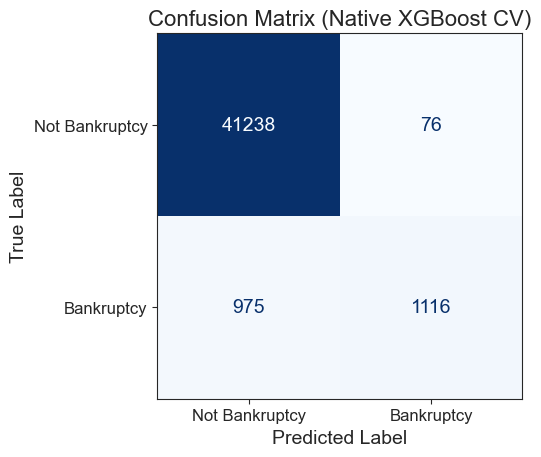

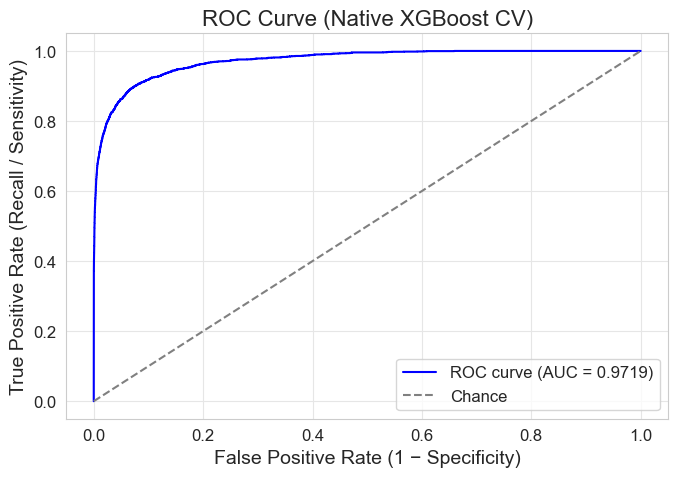

In [85]:
# best_params and best_num_rounds already selected
# Prepare arrays to collect predictions
oof_preds = np.zeros_like(y, dtype=float)   # Stores predicted probabilities for each fold
oof_labels = np.zeros_like(y, dtype=int)    # Stores final predicted class (0/1) for each fold
rounds_per_fold = []

# Set up cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Time CV predictions with final model
start = time.perf_counter()

for train_idx, valid_idx in kf.split(X, y):                  # Loops through the 5 train-validation splits 
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)

    # # Use this if you want to set best_num_rounds from earlier
    # model = xgb.train(
    #     params=best_params,
    #     dtrain=dtrain,
    #     num_boost_round=best_num_rounds,  
    #     verbose_eval=False
    # )

    model = xgb.train(
        params=best_params,
        dtrain=dtrain,
        evals=[(dvalid, "eval")],            # required for early stopping
        num_boost_round=1000,
        early_stopping_rounds=10
    )

    preds = model.predict(dvalid)                     # Probabilities [0,1]
    oof_preds[valid_idx] = preds                      # Save probabilities
    oof_labels[valid_idx] = (preds > 0.5).astype(int) # Convert to 0/1 label and store
    rounds_per_fold.append(model.best_iteration + 1)

end = time.perf_counter()
print(f"Elapsed time for CV XGB predictions:: {((end - start)/60):.3f} minutes")

# Rename for combined plotting with RF later
xgb_oof_probs = oof_preds
xgb_oof_labels = oof_labels

# Now evaluate
print("Best XGB Params:\n", best_params)
print("Boosting rounds per fold:", rounds_per_fold)
print("Classification Report:\n", classification_report(y, oof_labels))
print("Confusion Matrix:\n", confusion_matrix(y, oof_labels))
print("AUC:", roc_auc_score(y, oof_preds))

# # ROC curve
# fpr, tpr, _ = roc_curve(y, oof_preds)
# RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
# plt.title("ROC Curve (Native XGBoost CV)")
# plt.show()

# Very simple way to make a confusion matrix plot
# Class labels for ticks (e.g., 0 = Not Bankrupcy, 1 = Bankrupcy)
class_order = ['Not Bankruptcy', 'Bankruptcy']

# Set Seaborn style
sns.set_style('ticks')

# Create and customize the plot
disp = ConfusionMatrixDisplay.from_predictions(y, oof_labels, cmap='Blues', colorbar=False)

# Now set tick labels on the returned axis
disp.ax_.set_xticklabels(class_order)
disp.ax_.set_yticklabels(class_order)
disp.ax_.set_xlabel("Predicted Label")
disp.ax_.set_ylabel("True Label")
disp.ax_.set_title("Confusion Matrix (Native XGBoost CV)")

plt.tight_layout()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, oof_preds)
roc_auc = auc(fpr, tpr)

# Set a cleaner seaborn style with lighter grid
sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '.9'})

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
plt.xlabel("False Positive Rate (1 − Specificity)")
plt.ylabel("True Positive Rate (Recall / Sensitivity)")
plt.title("ROC Curve (Native XGBoost CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# CV_boosting_rounds:

#### Random Forest

##### Hyperparameter Tuning

In [86]:
# X, y already created
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=SEED)  # 100 estimators for tuning

rf_params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [2, 4, 6, 8, 10, 12, 15, 20, 25],  # same as for xgb
    'max_features': ['sqrt', 'log2', 0.5, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 4, 8],
}

# Define multiple scorers
scoring = {
    'auc': 'roc_auc',
    'accuracy': make_scorer(accuracy_score)
}

rf_search = RandomizedSearchCV(
    rf, rf_params,
    n_iter=30, cv=cv, 
    scoring=scoring, refit='auc',  # Use AUC to choose best estimator
    verbose=2, n_jobs=-1,
    # verbose=2, n_jobs=2,
    random_state=SEED,
    return_train_score=True
)

# Time hypertuning
start = time.perf_counter()

rf_search.fit(X, y)

end = time.perf_counter()
print(f"Elapsed time for CV RF predictions: {((end - start)/60):.3f} minutes")

print("Best AUC:", rf_search.best_score_)
print("Best Parameters:", rf_search.best_params_)

results = pd.DataFrame(rf_search.cv_results_)
print(results[['mean_test_auc', 'mean_test_accuracy', 'params']].sort_values(by='mean_test_auc', ascending=False))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=4, min_samples_split=8; total time=  37.9s
[CV] END criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=4, min_samples_split=8; total time=  38.4s
[CV] END criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=4, min_samples_split=8; total time=  38.7s
[CV] END criterion=gini, max_depth=6, max_features=None, min_samples_leaf=1, min_samples_split=2; total time= 1.3min
[CV] END criterion=gini, max_depth=6, max_features=None, min_samples_leaf=1, min_samples_split=2; total time= 1.3min
[CV] END criterion=gini, max_depth=6, max_features=0.5, min_samples_leaf=4, min_samples_split=8; total time=  38.9s
[CV] END criterion=gini, max_depth=6, max_features=None, min_samples_leaf=1, min_samples_split=2; total time= 1.3min
[CV] END criterion=gini, max_depth=6, max_features=None, min_samples_leaf=1, min_samples_split=2; total time= 1.3min
[CV] E

       AUC  Accuracy  Std AUC
29  0.9525    0.9694   0.0035
13  0.9507    0.9696   0.0020
9   0.9489    0.9684   0.0031
16  0.9478    0.9683   0.0028
23  0.9469    0.9679   0.0027
7   0.9464    0.9679   0.0022
24  0.9371    0.9607   0.0036
22  0.9321    0.9435   0.0030
17  0.9296    0.9618   0.0049
11  0.9258    0.9578   0.0056

1. {'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 25, 'criterion': 'entropy'}

2. {'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 25, 'criterion': 'gini'}

3. {'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 25, 'criterion': 'gini'}

4. {'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 25, 'criterion': 'gini'}

5. {'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 25, 'criterion': 'gini'}

6. {'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 15, 'criterion': 'entr

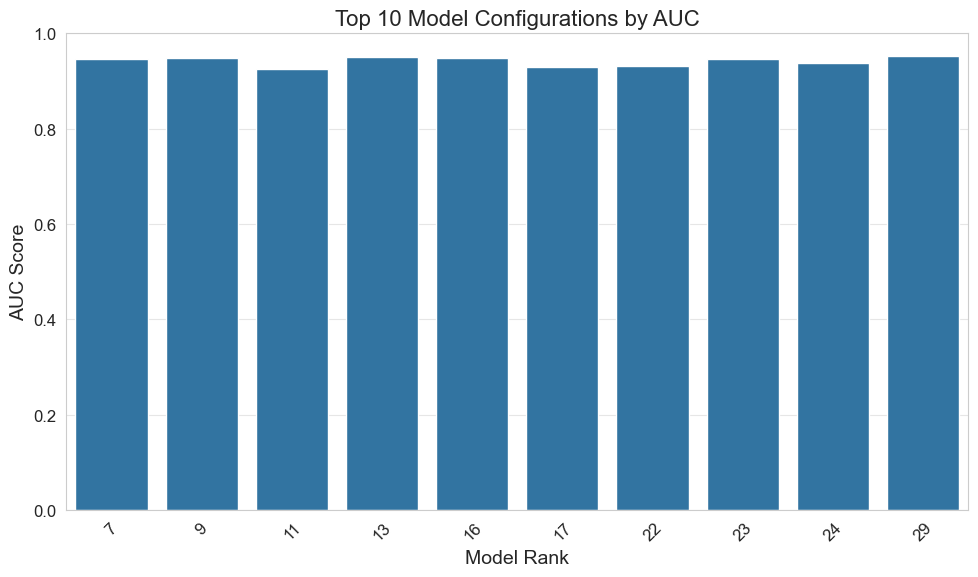

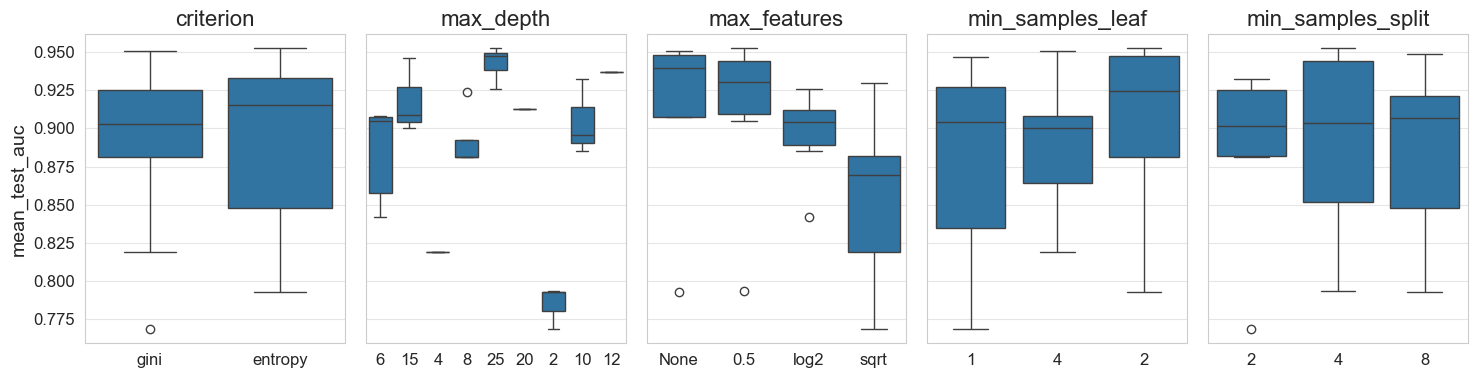

In [87]:
# Option 1: Create a cleaner DataFrame with just the key information
top_results = pd.DataFrame({
    'AUC': results['mean_test_auc'],
    'Accuracy': results['mean_test_accuracy'],
    'Std AUC': results['std_test_auc'],
    'Params': results['params']
}).sort_values(by='AUC', ascending=False).head(10)

# Display with better formatting
print(top_results[['AUC', 'Accuracy', 'Std AUC']].round(4))
for i, params in enumerate(top_results['Params']):
    print(f"\n{i+1}. {params}")

# Option 2: Visualize the top results
plt.figure(figsize=(10, 6))
sns.barplot(x=top_results.index[:10], y='AUC', data=top_results)
plt.title('Top 10 Model Configurations by AUC')
plt.ylabel('AUC Score')
plt.xlabel('Model Rank')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Option 3: Parameter importance visualization
param_names = list(rf_params.keys())
param_values = []
for param in param_names:
    param_values.append([str(p[param]) for p in results['params']])

fig, axes = plt.subplots(1, len(param_names), figsize=(15, 4), sharey=True)
for i, (param, values) in enumerate(zip(param_names, param_values)):
    sns.boxplot(x=values, y=results['mean_test_auc'], ax=axes[i])
    axes[i].set_title(param)
    axes[i].set_xlabel('')
    if i > 0:
        axes[i].set_ylabel('')
plt.tight_layout()
plt.show()

##### Fit the Final Model and Get Metrics

{'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 25, 'criterion': 'entropy'}
Elapsed time for CV RF predictions: 4.823 minutes
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     41314
           1       0.92      0.41      0.56      2091

    accuracy                           0.97     43405
   macro avg       0.94      0.70      0.77     43405
weighted avg       0.97      0.97      0.96     43405

Confusion Matrix:
 [[41237    77]
 [ 1244   847]]
AUC: 0.9593717783995184


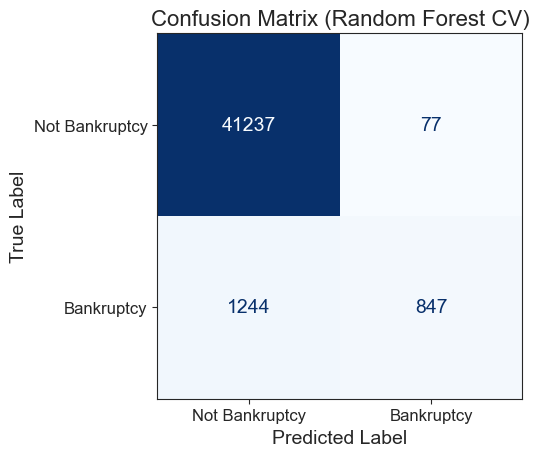

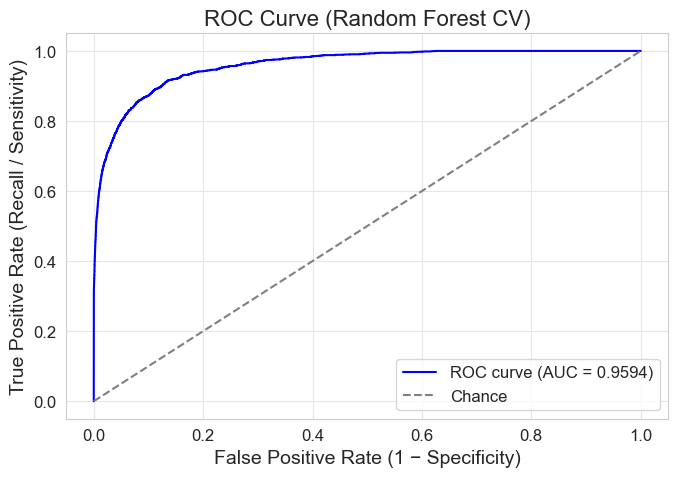

In [88]:
# Get the best parameters
# print(rf_search.best_params_)
best_params = rf_search.best_params_ # this should work but it doesn't, it is rerunning the full param grid
print(best_params)
best_rf = RandomForestClassifier(min_samples_split=4, 
                                 min_samples_leaf=2,
                                 max_features=0.5,
                                 max_depth=25,
                                 criterion='entropy',
                                 n_estimators=1000,
                                 class_weight='balanced',
                                 random_state=SEED,
                                 n_jobs=-1)

# Set up CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Time final modle
start = time.perf_counter()

# Get OOF predicted labels
oof_labels = cross_val_predict(best_rf, X, y, cv=cv)

end = time.perf_counter()
print(f"Elapsed time for CV RF predictions: {((end - start)/60):.3f} minutes")

# Get OOF predicted probabilities for positive class (Bankrupcy = 1)
oof_probs = cross_val_predict(best_rf, X, y, cv=cv, method='predict_proba')[:, 1]

# Rename for combined plotting with XGB later
rf_oof_probs = oof_probs
rf_oof_labels = oof_labels

# Evaluate
print("Classification Report:\n", classification_report(y, oof_labels))
print("Confusion Matrix:\n", confusion_matrix(y, oof_labels))
print("AUC:", roc_auc_score(y, oof_probs))


# Very simple way to make a confusion matrix plot
# Class labels for ticks (e.g., 0 = Not Bankrupcy, 1 = Bankrupcy)
class_order = ['Not Bankruptcy', 'Bankruptcy']

# Set Seaborn style
sns.set_style('ticks')

# Create and customize the plot
disp = ConfusionMatrixDisplay.from_predictions(y, oof_labels, cmap='Blues', colorbar=False)

# Now set tick labels on the returned axis
disp.ax_.set_xticklabels(class_order)
disp.ax_.set_yticklabels(class_order)
disp.ax_.set_xlabel("Predicted Label")
disp.ax_.set_ylabel("True Label")
disp.ax_.set_title("Confusion Matrix (Random Forest CV)")

plt.tight_layout()
plt.show()

# # ROC Curve
# fpr, tpr, _ = roc_curve(y, oof_probs)
# RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
# plt.title("ROC Curve (Random Forest CV)")
# plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, oof_probs)
roc_auc = auc(fpr, tpr)

# Set a cleaner seaborn style with lighter grid
sns.set_style("whitegrid", {'axes.grid': True, 'grid.color': '.9'})

# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')
plt.xlabel("False Positive Rate (1 − Specificity)")
plt.ylabel("True Positive Rate (Recall / Sensitivity)")
plt.title("ROC Curve (Random Forest CV)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Get Combined Plots

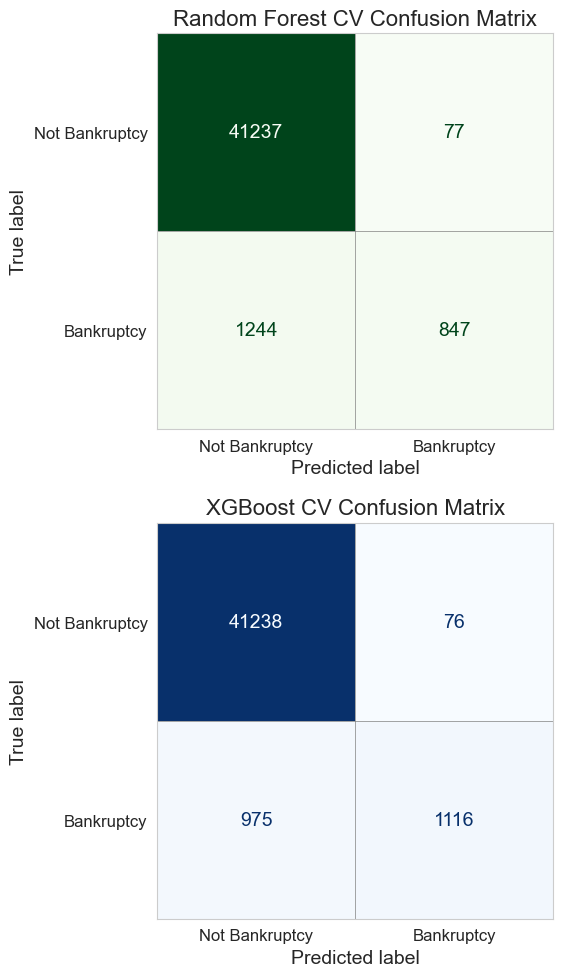

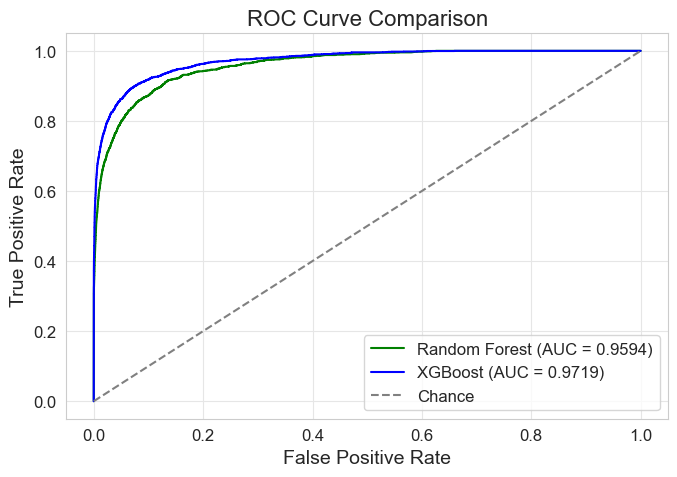

In [89]:
# Store everything under different variable names to avoid overwrite
fpr_rf, tpr_rf, _ = roc_curve(y, rf_oof_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y, xgb_oof_probs)
# roc_auc_rf = auc(fpr_rf, tpr_rf)
# roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
# Calculate AUC using roc_auc_score directly for consistency
roc_auc_rf = roc_auc_score(y, rf_oof_probs)
roc_auc_xgb = roc_auc_score(y, xgb_oof_probs)

# ================================
# 1. Side-by-Side Confusion Matrices
# ================================
fig, axs = plt.subplots(2, 1, figsize=(6, 10))

# RF Confusion Matrix
rf_disp = ConfusionMatrixDisplay.from_predictions(
    y, rf_oof_labels, ax=axs[0], cmap='Greens', colorbar=False
)
axs[0].set_title("Random Forest CV Confusion Matrix")
axs[0].set_xticklabels(class_order)
axs[0].set_yticklabels(class_order)
axs[0].grid(False)  # Turn off grid
axs[0].axhline(0.5, color='gray', linewidth=0.5)
axs[0].axvline(0.5, color='gray', linewidth=0.5)

# XGB Confusion Matrix
xgb_disp = ConfusionMatrixDisplay.from_predictions(
    y, xgb_oof_labels, ax=axs[1], cmap='Blues', colorbar=False
)
axs[1].set_title("XGBoost CV Confusion Matrix")
axs[1].set_xticklabels(class_order)
axs[1].set_yticklabels(class_order)
axs[1].grid(False)
axs[1].axhline(0.5, color='gray', linewidth=0.5)
axs[1].axvline(0.5, color='gray', linewidth=0.5)

plt.tight_layout()
plt.show()

# ================================
# 2. ROC Curve Plot
# ================================
plt.figure(figsize=(7, 5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})", color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Model Performance Metrics:
           XGBoost Mean  XGBoost Std  RF Mean  RF Std
Accuracy         0.9758       0.0013   0.9696  0.0014
Precision        0.9362       0.0171   0.9167  0.0268
Recall           0.5337       0.0328   0.4051  0.0232
AUC              0.9719       0.0027   0.9594  0.0014


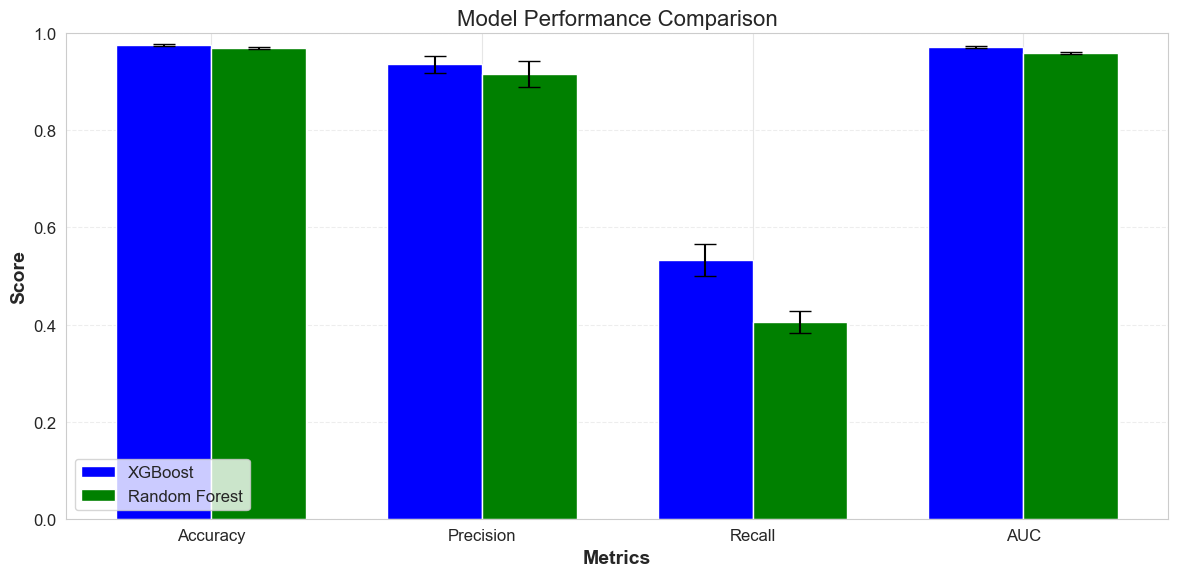

In [90]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

# Calculate overall metrics directly from existing OOF predictions
overall_metrics = {
    'xgb': {
        'accuracy': accuracy_score(y, (xgb_oof_probs > 0.5).astype(int)),
        'precision': precision_score(y, (xgb_oof_probs > 0.5).astype(int)),
        'recall': recall_score(y, (xgb_oof_probs > 0.5).astype(int)),
        'auc': roc_auc_score(y, xgb_oof_probs)
    },
    'rf': {
        'accuracy': accuracy_score(y, (rf_oof_probs > 0.5).astype(int)),
        'precision': precision_score(y, (rf_oof_probs > 0.5).astype(int)),
        'recall': recall_score(y, (rf_oof_probs > 0.5).astype(int)),
        'auc': roc_auc_score(y, rf_oof_probs)
    }
}

# Function to calculate metrics across the SAME folds used to generate OOF predictions
def calculate_fold_metrics(y_true, y_pred_probs, threshold=0.5, n_splits=5):
    # Convert probabilities to binary predictions using threshold
    y_pred = (y_pred_probs > threshold).astype(int)
    
    # Initialize arrays to store metrics for each fold
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'auc': []
    }
    
    # Calculate metrics for each fold
    for train_idx, valid_idx in kf.split(X, y_true):
        y_true_fold = y_true.iloc[valid_idx]
        y_pred_fold = y_pred[valid_idx]
        y_proba_fold = y_pred_probs[valid_idx]
        
        fold_metrics['accuracy'].append(accuracy_score(y_true_fold, y_pred_fold))
        fold_metrics['precision'].append(precision_score(y_true_fold, y_pred_fold))
        fold_metrics['recall'].append(recall_score(y_true_fold, y_pred_fold))
        fold_metrics['auc'].append(roc_auc_score(y_true_fold, y_proba_fold))
    
    # Return standard deviations only
    return {k: np.std(v) for k, v in fold_metrics.items()}

# Calculate standard deviations across folds
xgb_stds = calculate_fold_metrics(y, xgb_oof_probs)
rf_stds = calculate_fold_metrics(y, rf_oof_probs)

# Create a DataFrame to display results
metrics_df = pd.DataFrame({
    'XGBoost Mean': [overall_metrics['xgb']['accuracy'], 
                    overall_metrics['xgb']['precision'], 
                    overall_metrics['xgb']['recall'], 
                    overall_metrics['xgb']['auc']],
    'XGBoost Std': [xgb_stds['accuracy'], xgb_stds['precision'], 
                   xgb_stds['recall'], xgb_stds['auc']],
    'RF Mean': [overall_metrics['rf']['accuracy'], 
               overall_metrics['rf']['precision'], 
               overall_metrics['rf']['recall'], 
               overall_metrics['rf']['auc']],
    'RF Std': [rf_stds['accuracy'], rf_stds['precision'], 
              rf_stds['recall'], rf_stds['auc']]
}, index=['Accuracy', 'Precision', 'Recall', 'AUC'])

print("Model Performance Metrics:")
print(metrics_df.round(4))

# Create a visualization with 4 metrics instead of 3
plt.figure(figsize=(12, 6))
barWidth = 0.35
r1 = np.arange(4)
r2 = [x + barWidth for x in r1]

# Create bars with blue for XGBoost and green for Random Forest
plt.bar(r1, metrics_df['XGBoost Mean'], width=barWidth, edgecolor='white', 
        yerr=metrics_df['XGBoost Std'], capsize=8, label='XGBoost', color='blue')
plt.bar(r2, metrics_df['RF Mean'], width=barWidth, edgecolor='white',
        yerr=metrics_df['RF Std'], capsize=8, label='Random Forest', color='green')

# Add labels and legend
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(4)], ['Accuracy', 'Precision', 'Recall', 'AUC'])
plt.title('Model Performance Comparison')
plt.legend()
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()